# This file is for SSA-CNN model with 252 L dataset

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import matplotlib.pyplot as plt
import sys

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

## Read in my python class
from Window_Generator_package import Window_Generator

2023-07-30 14:58:03.028365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 14:58:04.059313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_path = './Data/Parameter_tuning_0.9997/252/Train/'
test_path = './Data/Parameter_tuning_0.9997/252/Test/'
full_path = './Data/Grouped/'

# stock_example = pd.read_csv(path + 'Data/Grouped/Consumer and Service Sectors/ALL.AX.csv')
def read_stock(path, file_name):
    stock = pd.read_csv(path + file_name, header = [0])
    stock_index = pd.to_datetime(stock['Date'])
    stock.index = stock_index
    stock = stock.drop('Date', axis = 1)
    return stock
group = ['Consumer and Service Sectors', 'Financial, Healthcare, Technology, and Utilities Sectors', 'Industrial and Infrastructure Sectors']
index = [0, 1, 2]
def read_all(the_path):
    All_df = []
    files = [f for f in os.listdir(the_path) if f.endswith('.csv')]

    for name in files:
        stock = read_stock(the_path + '/', name)
        All_df.append(stock)
    return All_df, files
train_All_df_0, train_files = read_all(train_path + group[index[0]])
test_All_df_0, test_files = read_all(test_path + group[index[0]])
full_All_df_0, full_files = read_all(full_path + group[index[0]])
example_train = train_All_df_0[0]
example_test = test_All_df_0[0]
example_actual = full_All_df_0[0][5:]

In [3]:
train_series_1 = example_train.iloc[:, 0]
test_series_1 = example_test.iloc[:, 0]

In [4]:
MAX_EPOCHS = 30

def compile_and_fit(model, X_train, Y_train, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, Y_train, epochs=MAX_EPOCHS, verbose = 0)
  return history

In [5]:
def cnn_model(window_length):
  cnn = Sequential()
  cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(5, 1), padding = 'same'))
  cnn.add(Conv1D(filters=64, kernel_size=window_length, activation='relu', input_shape=(5, 1)))
  cnn.add(Dense(64, activation='relu'))
  cnn.add(Dense(1, activation = 'linear'))
  return cnn

cnn = cnn_model(window_length = 5)

2023-07-30 14:58:07.467512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-30 14:58:07.644642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-30 14:58:07.645018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-30 14:58:07.646400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-30 14:58:07.646719: I tensorflow/compile

In [6]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             256       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             20544     
                                                                 
 dense (Dense)               (None, 1, 64)             4160      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 25,025
Trainable params: 25,025
Non-trainable params: 0
_________________________________________________________________


In [7]:
def obtain_prediction(X_train, Y_train, X_test, Y_test, window_length = 5):
  # The input train and test are all 3D list
  predicted_train_list = []
  predicted_test_list = []
  train_MAE_list = []
  test_MAE_list = []
  for i in range(5):
    cnn = cnn_model(window_length)
    history = compile_and_fit(cnn, X_train = X_train, Y_train = Y_train)
    # IPython.display.clear_output()
    train_performance = cnn.evaluate(X_train, Y_train)[1]
    test_performance = cnn.evaluate(X_test, Y_test)[1]
    # print('Train:', str(train_performance))
    # print('Test:', str(test_performance))
    Y_predict_train = cnn.predict(X_train)
    Y_predict_train = Y_predict_train.reshape(len(Y_predict_train))
    predicted_train_list.append(Y_predict_train)

    Y_predict_test = cnn.predict(X_test)
    Y_predict_test = Y_predict_test.reshape(len(Y_predict_test))
    predicted_test_list.append(Y_predict_test)

    train_MAE_list.append(train_performance)
    test_MAE_list.append(test_performance)

  train_MAE = np.mean(train_MAE_list)
  test_MAE = np.mean(test_MAE_list)

  predicted_train_list = np.array(predicted_train_list)
  predicted_train_list = np.mean(predicted_train_list, axis = 0)
  predicted_test_list = np.array(predicted_test_list)
  predicted_test_list = np.mean(predicted_test_list, axis = 0)

  return predicted_train_list, predicted_test_list, train_MAE, test_MAE

In [8]:
# Get result of 1 train and test series
def obtain_ONE_series(train_series, test_series, window_length = 5, show = None):

  # Data Preparation
  w = Window_Generator(train_series = train_series, test_series = test_series)
  _, _, train_mean, train_std, test_mean, test_std = w.standardization(show=True)
  _, _, _, _ = w.window_generation(show = True)
  X_train, X_test, Y_train, Y_test = w.data_getter()
  train_denormalized = w.denormalize_train()
  test_denormalized = w.denormalize_test()

  # Training and Prediction
  predicted_train_list, predicted_test_list, train_MAE, test_MAE = obtain_prediction(X_train, Y_train, X_test, Y_test, window_length = window_length)
  print('Train_MAE:', train_MAE)
  print('Test_MAE:', test_MAE)

  # Prediction Generation (Are train_set)

  train_index = w.train_index[w.window_length:]
  test_index = w.test_index

  Y_predict_train = pd.Series(predicted_train_list, index = train_index)
  Y_predict_train = Y_predict_train * train_std[w.window_length:] + train_mean[w.window_length:]
  Y_actual_train = Y_train.reshape(len(Y_train)) * train_std[w.window_length:] + train_mean[w.window_length:]
  Y_predict_train = pd.DataFrame(Y_predict_train, index = train_index)
  Y_actual_train = pd.DataFrame(Y_actual_train, index = train_index)

  Y_predict_test = pd.Series(predicted_test_list, index = test_index)
  Y_predict_test = Y_predict_test * test_std + test_mean
  Y_actual_test = Y_test.reshape(len(Y_test)) * test_std + test_mean
  Y_predict_test = pd.DataFrame(Y_predict_test, index = test_index)
  Y_actual_test = pd.DataFrame(Y_actual_test, index = test_index)

  if (show != None):
    plt.plot(Y_actual_train, label = 'Train Actual')
    plt.plot(Y_predict_train, label = 'Train predict')
    plt.plot(Y_actual_test, label = 'Test Actual')
    plt.plot(Y_predict_test, label = 'Test predict')
    plt.legend()
    plt.show()

  return Y_actual_train, Y_predict_train, Y_actual_test, Y_predict_test

In [9]:
def obtain_ONE_stock(train, test, show = None):
    length = len(train.columns)
    actual_train = []
    predict_train = []
    actual_test = []
    predict_test = []
    for i in range(length):
        train_series = train.iloc[:, i]
        test_series = test.iloc[:, i]
        Series_actual_train, Series_predict_train, Series_actual_test, Series_predict_test = obtain_ONE_series(train_series, test_series, window_length = 5, show = show)
        actual_train.append(Series_actual_train)
        predict_train.append(Series_predict_train)
        actual_test.append(Series_actual_test)
        predict_test.append(Series_predict_test)

    final_actual_train = pd.concat(actual_train)
    final_actual_train = final_actual_train.groupby(final_actual_train.index).sum()

    final_predict_train = pd.concat(predict_train)
    final_predict_train = final_predict_train.groupby(final_predict_train.index).sum()

    final_actual_test = pd.concat(actual_test)
    final_actual_test = final_actual_test.groupby(final_actual_test.index).sum()

    final_predict_test = pd.concat(predict_test)
    final_predict_test = final_predict_test.groupby(final_predict_test.index).sum()
    if (show != None):
        plt.plot(final_actual_train, label = 'Train Actual')
        plt.plot(final_predict_train, label = 'Train predict')
        plt.plot(final_actual_test, label = 'Test Actual')
        plt.plot(final_predict_test, label = 'Test predict')
        plt.legend()
        plt.show()

    return final_actual_train, final_predict_train, final_actual_test, final_predict_test

In [10]:
final_actual_train, final_predict_train, final_actual_test, final_predict_test = obtain_ONE_stock(example_train, example_test, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)


2023-07-30 14:58:11.981839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-30 14:58:13.778832: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-30 14:58:13.950777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-30 14:58:13.982789: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff10b0b2a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-30 14:58:13.982848: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-30 14:58:14.023208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-30 14:

KeyboardInterrupt: 

In [ ]:
Y_result = pd.concat([pd.concat([final_actual_train, final_predict_train], axis = 1), pd.concat([final_actual_test, final_predict_test], axis = 1)], axis = 0)
Y_result.columns = ['Smoothed_Actual', 'Predict']
Y_result = pd.concat([example_actual, Y_result], axis = 1)

## Here is the full combination:

In [11]:
store_path = './Data/Parameter_tuning_0.9997/252_Prediction/SSA-CNN/'
def obtain_all(the_index, window_length = 5, show = None):
    group_name = group[index[the_index]]
    train_All_df, train_files = read_all(train_path + group_name)
    test_All_df, test_files = read_all(test_path + group_name)
    full_All_df, full_files = read_all(full_path + group_name)
    total_length = len(full_All_df)

    for i in range(total_length):
        stock_name = full_files[i]
        train_series = train_All_df[i]
        test_series = test_All_df[i]
        final_actual_train, final_predict_train, final_actual_test, final_predict_test = obtain_ONE_stock(train_series, test_series, show = show)

        Y_result = pd.concat([pd.concat([final_actual_train, final_predict_train], axis = 1), pd.concat([final_actual_test, final_predict_test], axis = 1)], axis = 0)
        Y_result.columns = ['Smoothed_Actual', 'Predict']
        actual = full_All_df[i][5:]
        Y_result = pd.concat([actual, Y_result], axis = 1)
        Y_result.to_csv(store_path + group_name + '/' + stock_name)


train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.011814056895673275
Test_MAE: 0.04013173952698708


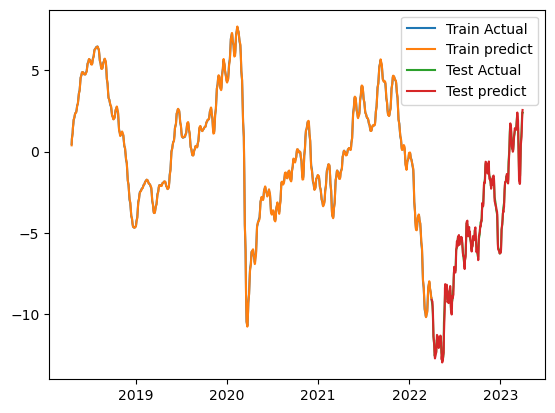

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002387692965567112
Test_MAE: 0.04116174876689911


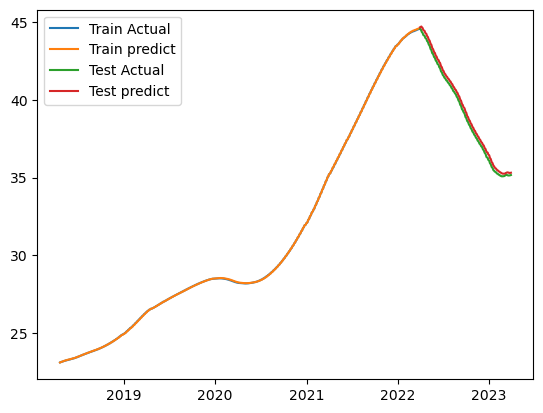

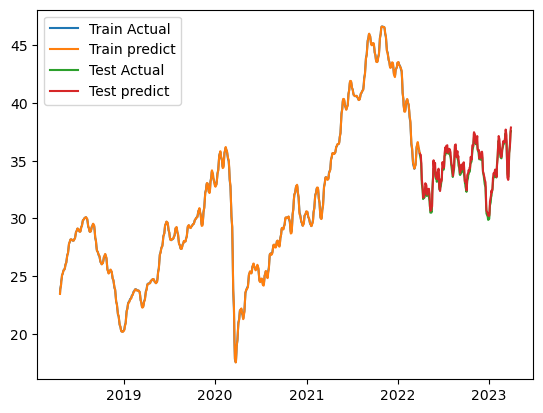

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.014152894541621209
Test_MAE: 0.059192148596048356


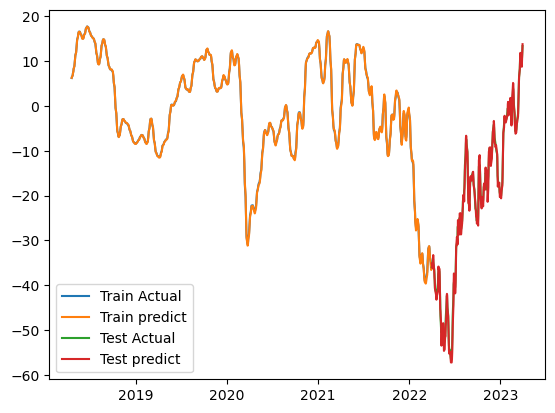

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0013256609789095819
Test_MAE: 0.032529677450656894


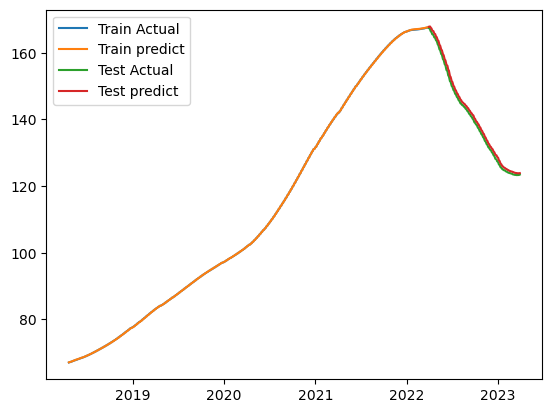

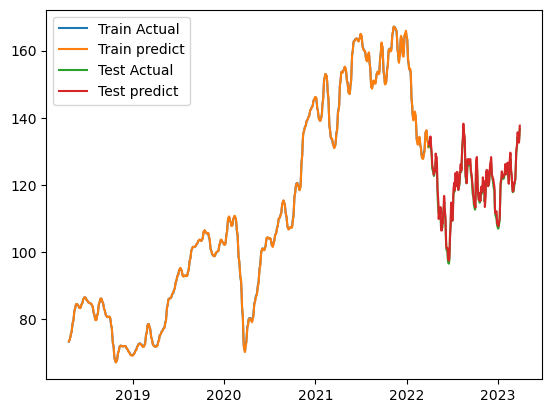

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.01305877547711134
Test_MAE: 0.02156347632408142


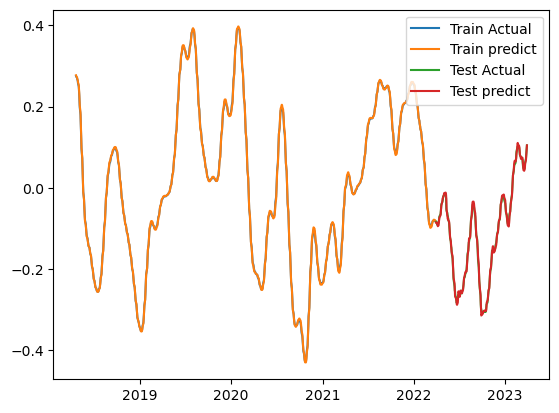

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.0038996753981336953
Test_MAE: 0.03100943863391876


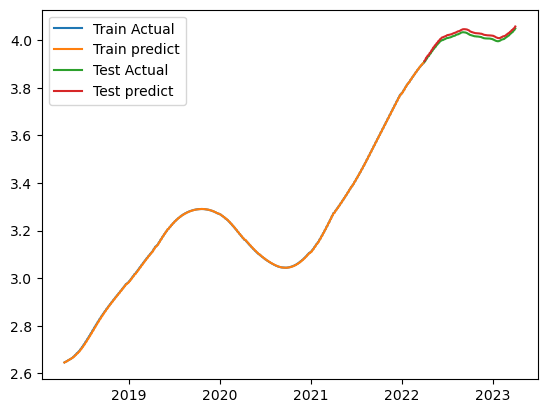

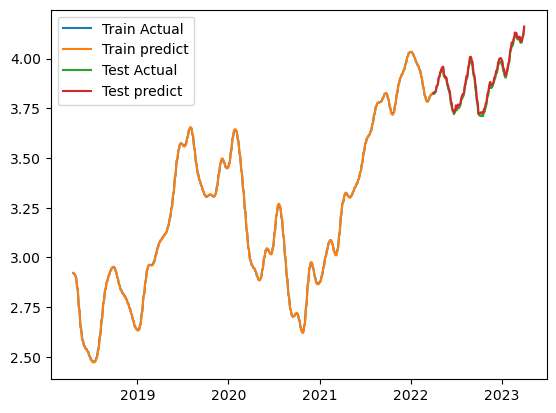

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.026402752473950387
Test_MAE: 0.045309508591890334


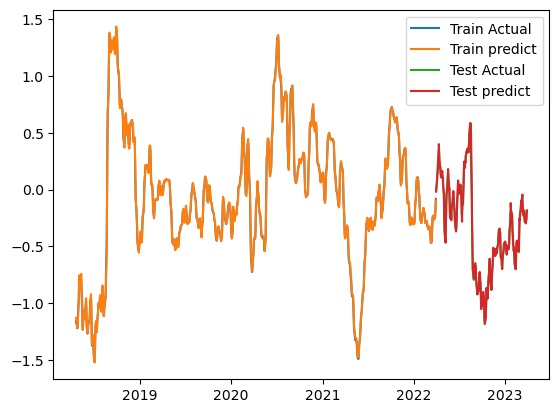

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0070935830939561125
Test_MAE: 0.015074996929615735


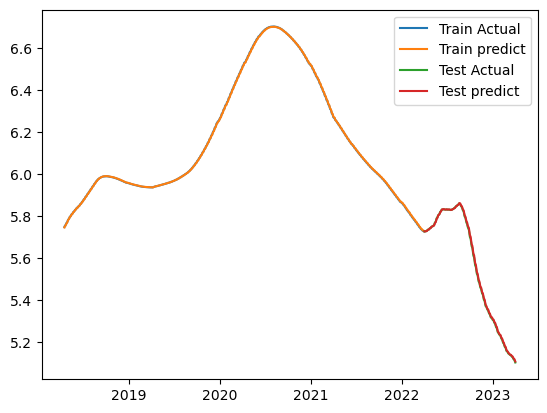

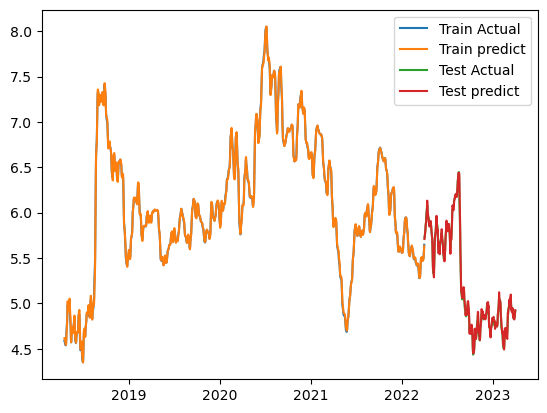

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.013228960521519183
Test_MAE: 0.0390505064278841


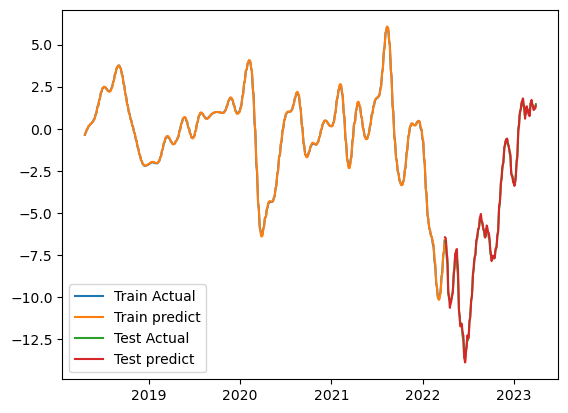

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.000999397929990664
Test_MAE: 0.028483249619603156


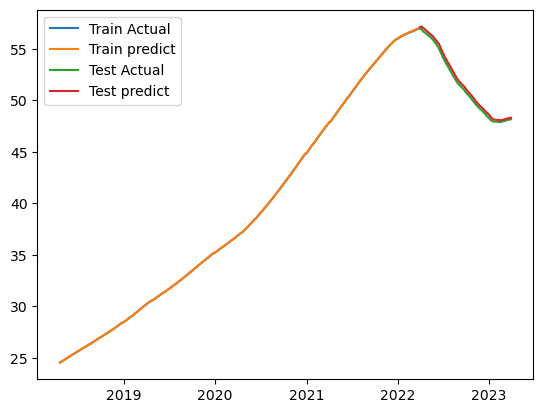

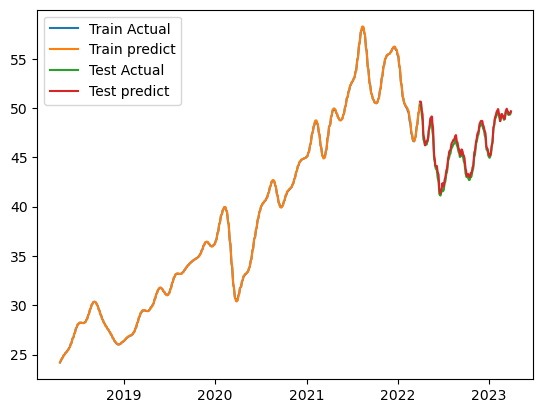

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.024644410237669945
Test_MAE: 0.04316958636045456


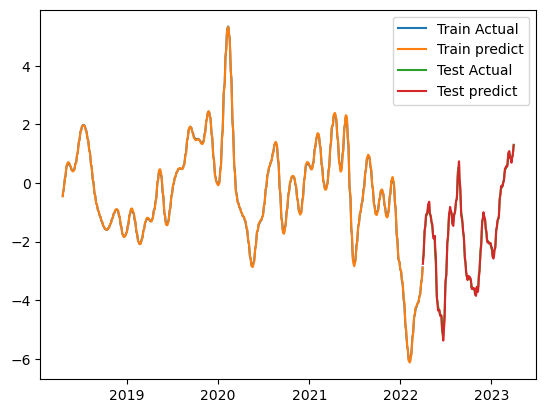

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0014987958827987313
Test_MAE: 0.014403566159307957


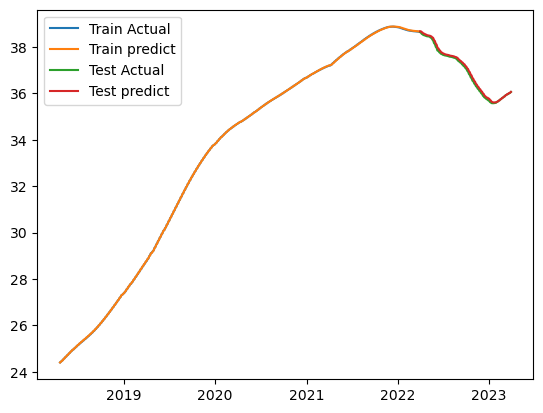

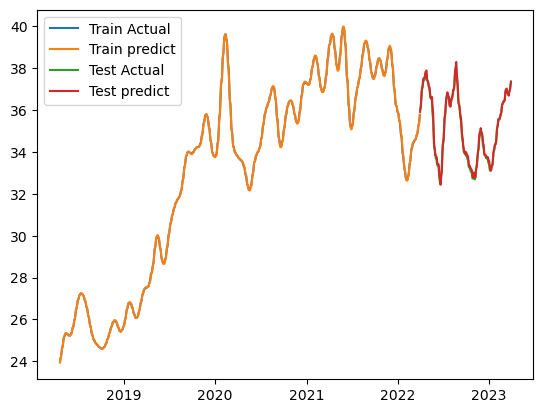

In [ ]:
obtain_all(0, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015790139511227607
Test_MAE: 0.039528583735227586


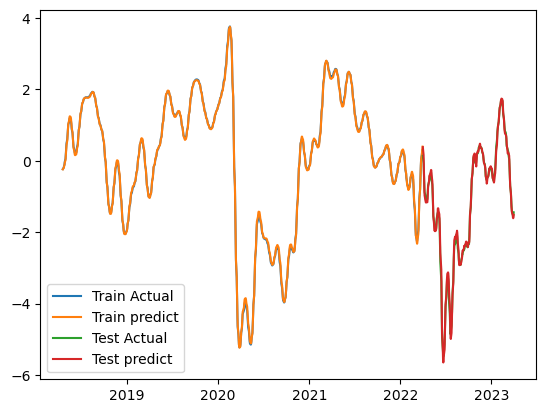

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006863144785165786
Test_MAE: 0.0389575146138668


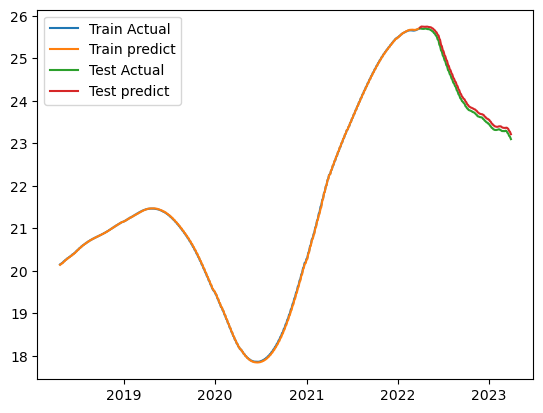

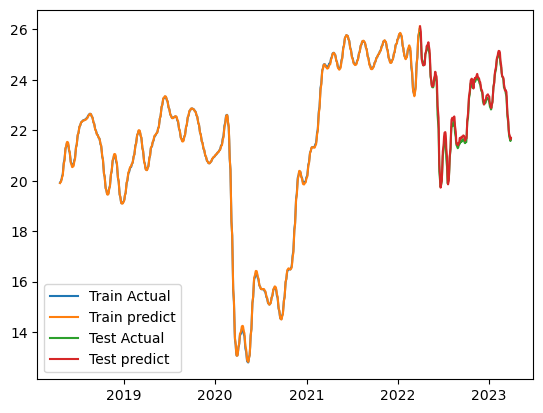

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015740423835813998
Test_MAE: 0.05373948141932487


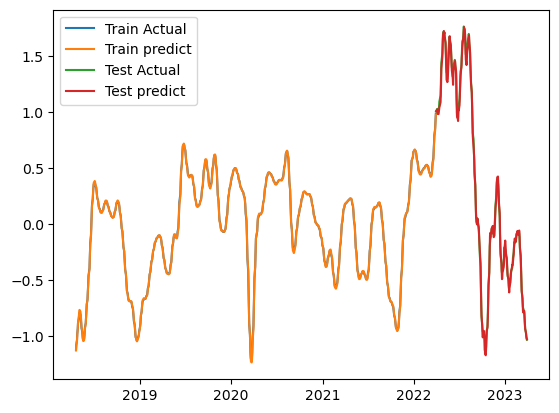

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005454012006521225
Test_MAE: 0.021492420323193075


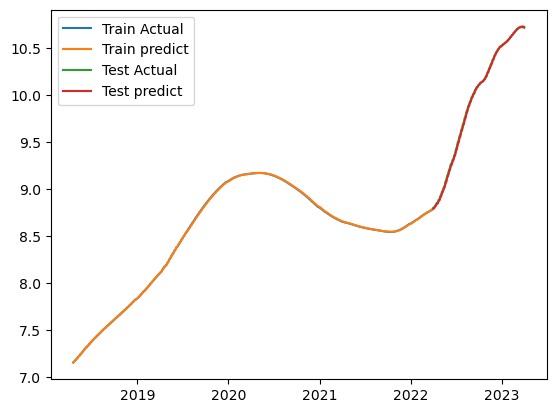

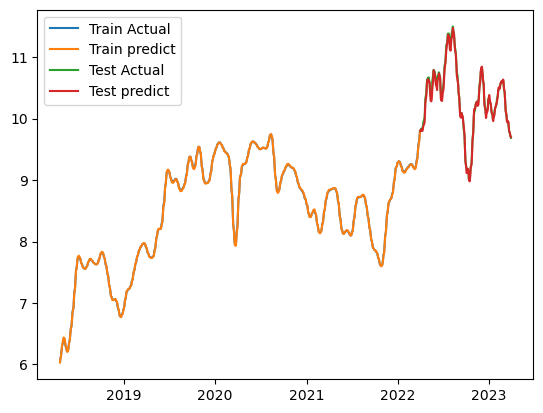

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.014084887504577637
Test_MAE: 0.03705939352512359


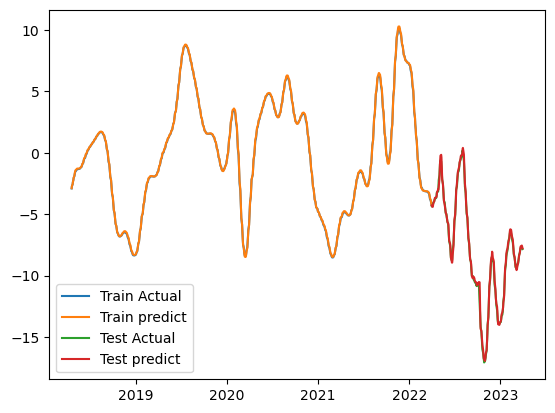

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0039774340111762285
Test_MAE: 0.028349853679537775


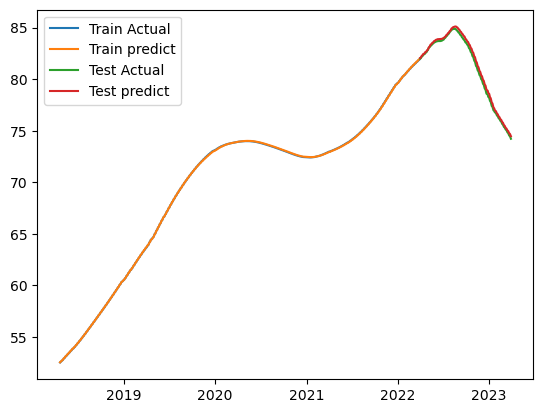

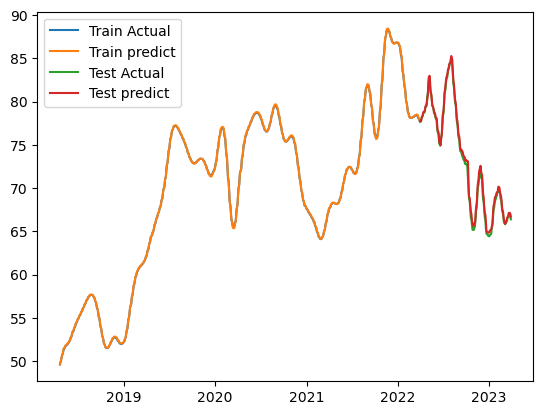

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.017069110833108424
Test_MAE: 0.056946571171283725


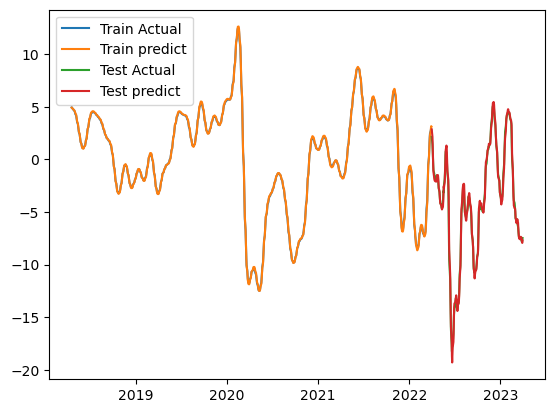

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002451054798439145
Test_MAE: 0.023313713446259498


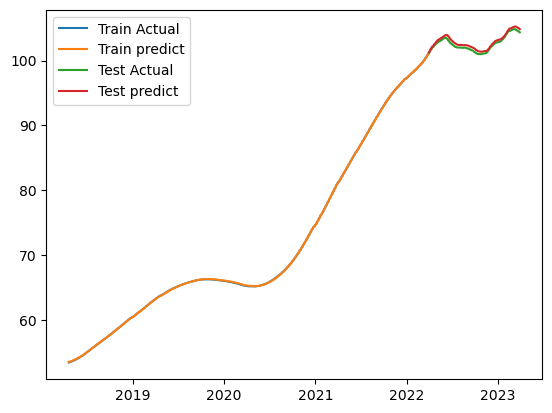

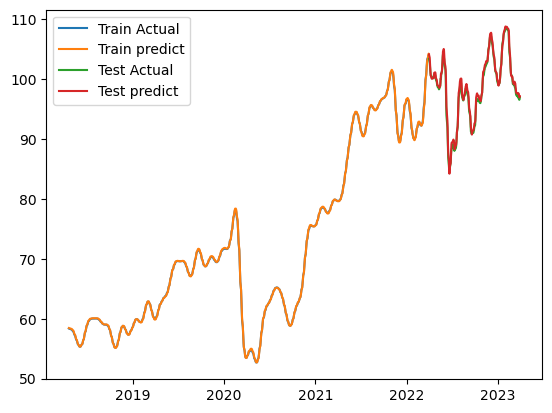

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01872202232480049
Test_MAE: 0.049557064473628995


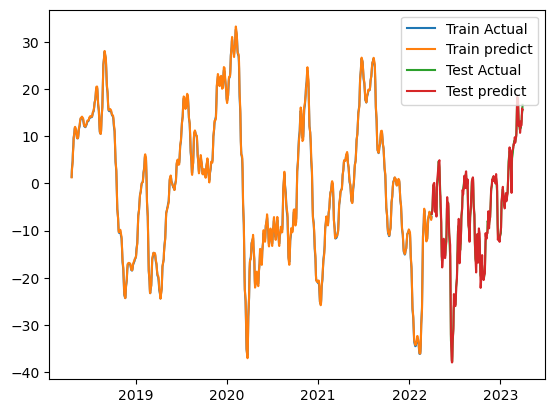

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0030500078573822975
Test_MAE: 0.024591072276234627


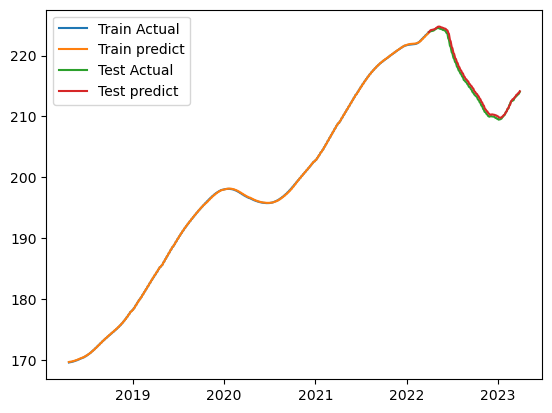

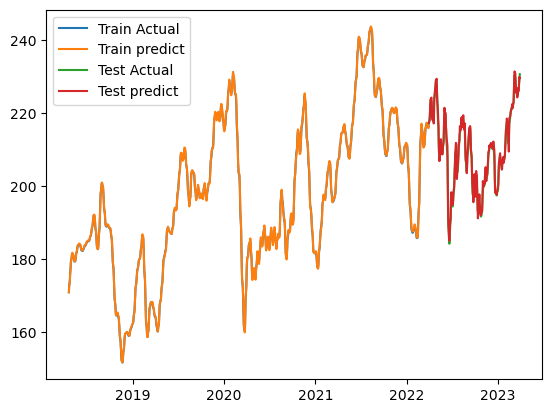

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.017392650619149207
Test_MAE: 0.06151602789759636


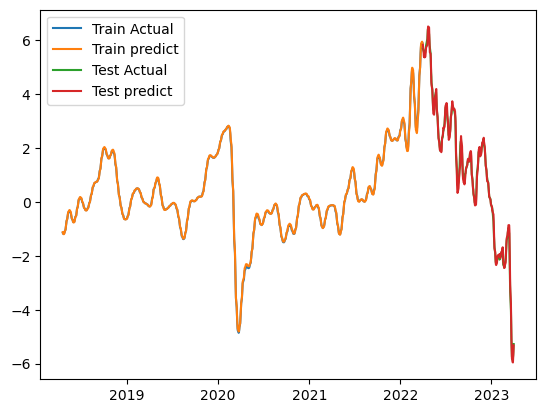

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009560540225356818
Test_MAE: 0.07736569494009018


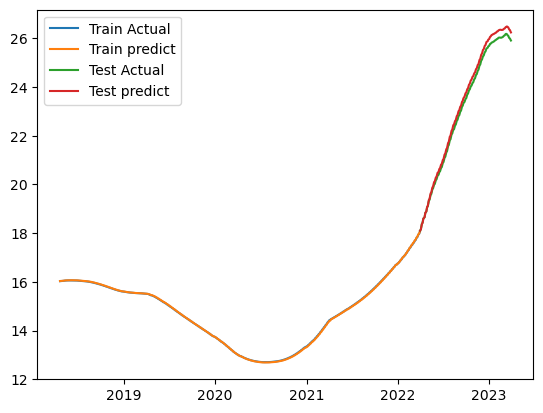

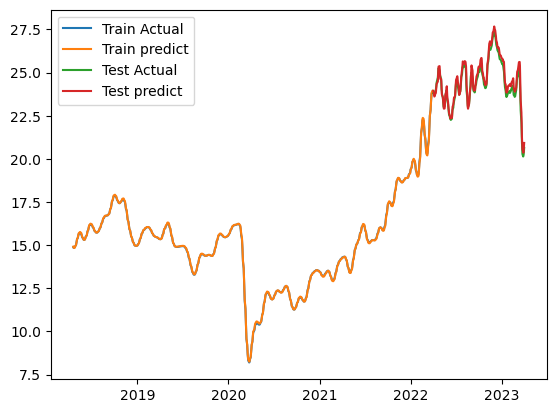

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.014450989291071891
Test_MAE: 0.0361549936234951


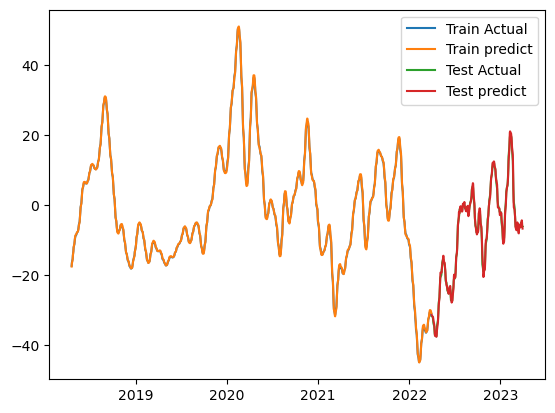

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0019203514792025089
Test_MAE: 0.007590728439390659


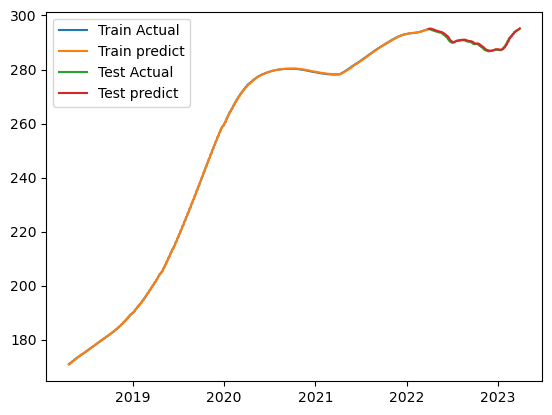

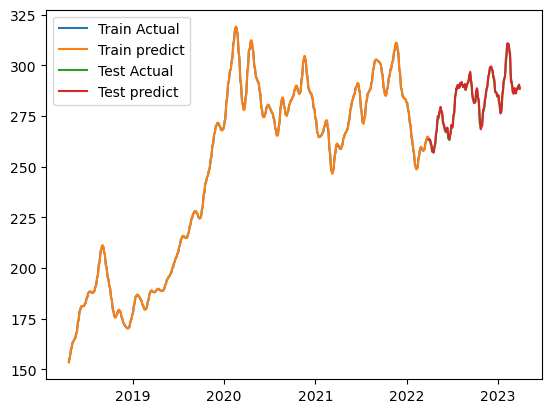

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.022247358039021493
Test_MAE: 0.04727584570646286


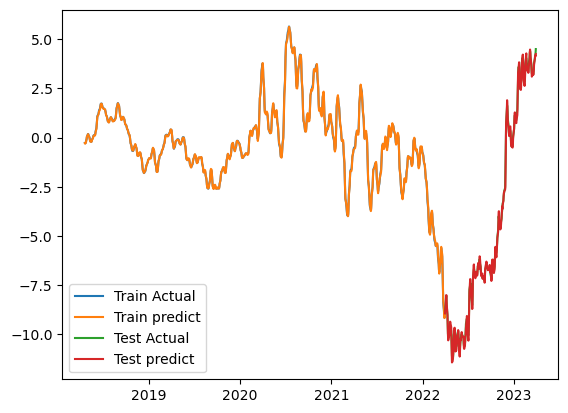

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.0016092801233753562
Test_MAE: 0.033197023719549176


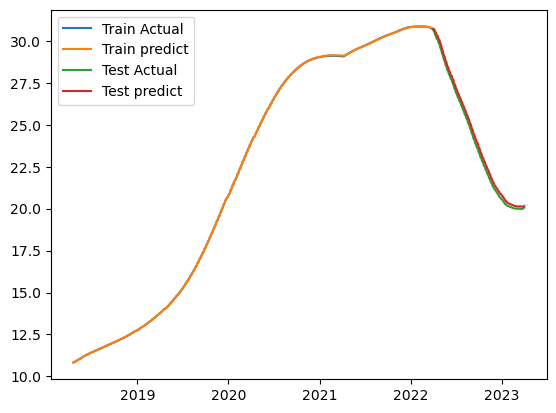

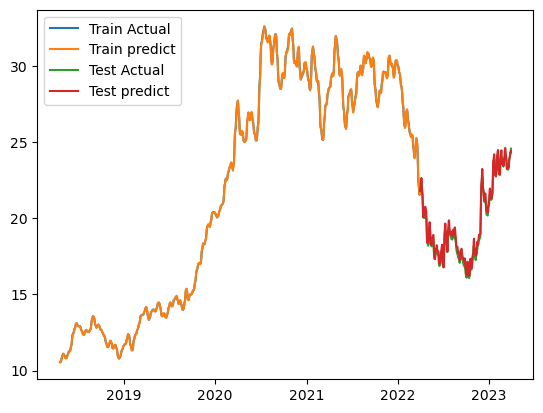

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.014774295315146447
Test_MAE: 0.06592891737818718


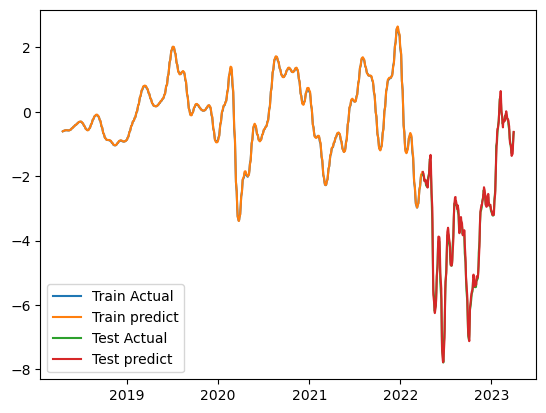

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.000973282172344625
Test_MAE: 0.03094080649316311


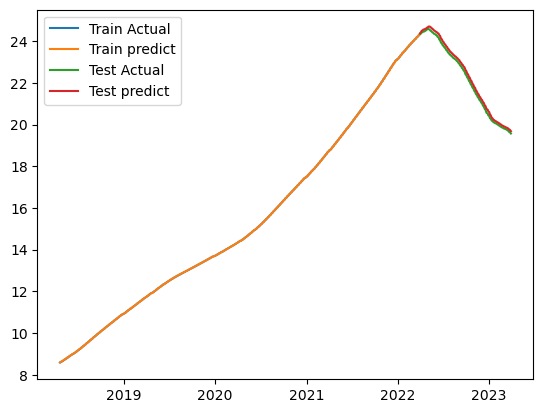

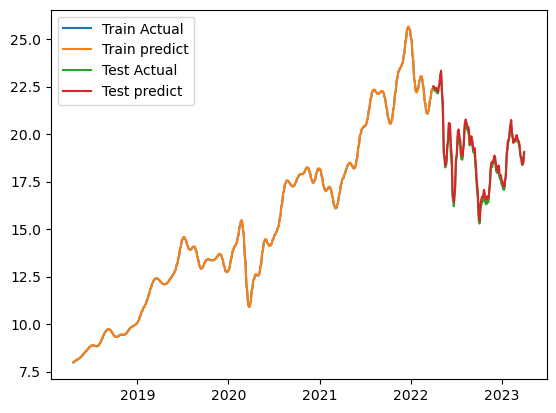

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.013764541875571013
Test_MAE: 0.029268331080675124


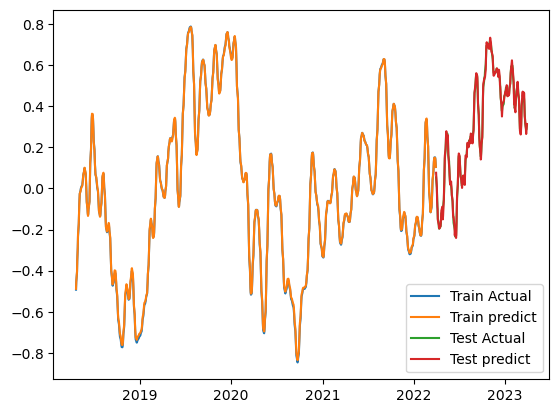

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.002610628888942301
Test_MAE: 0.008761388622224331


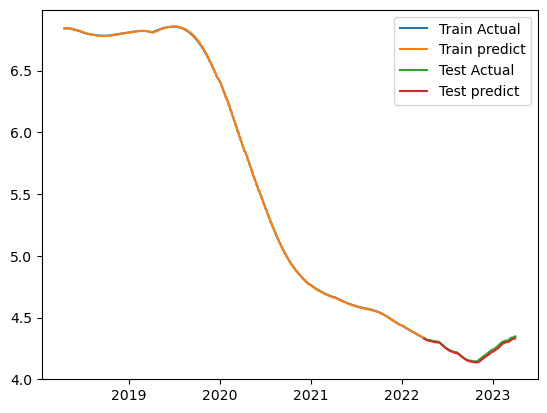

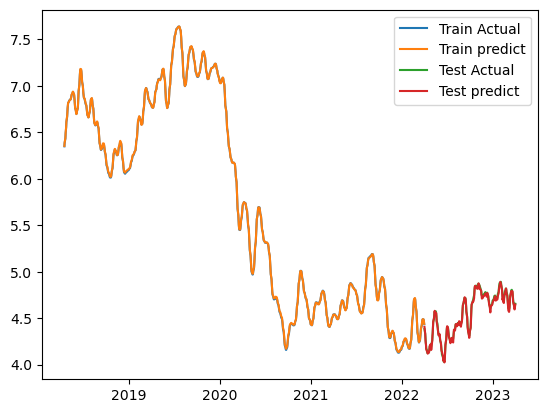

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01463444046676159
Test_MAE: 0.07105791568756104


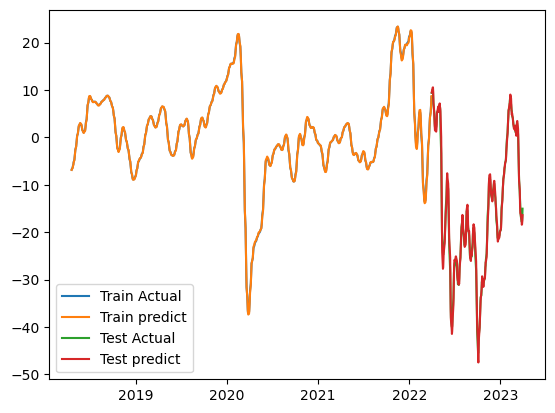

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 5ms/step
Train_MAE: 0.0023662531049922107
Test_MAE: 0.03696175962686539


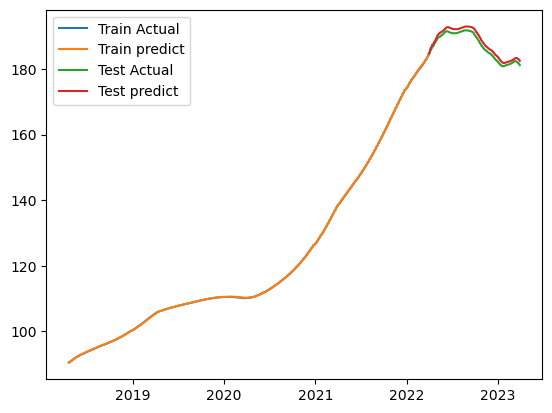

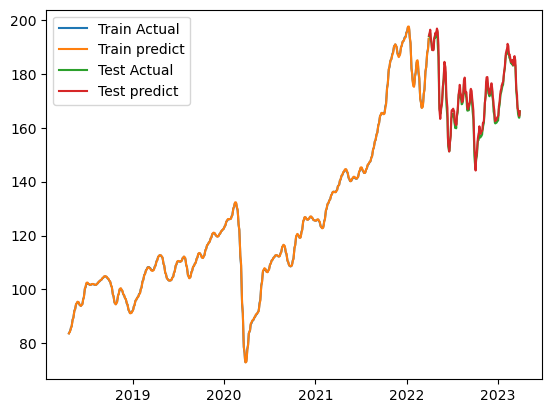

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.019156160950660705
Test_MAE: 0.04707785248756409


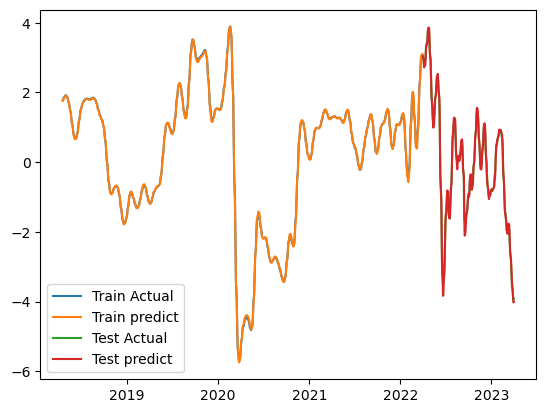

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.003789999918080866
Test_MAE: 0.024529723450541496


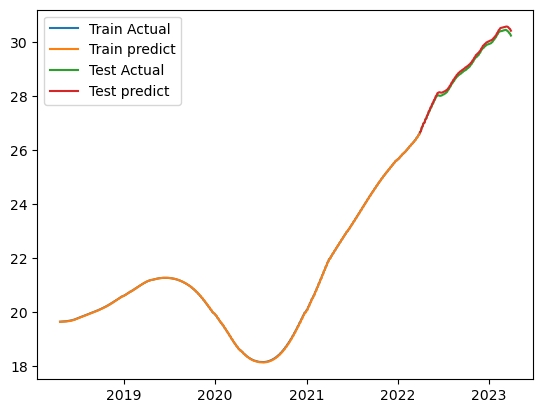

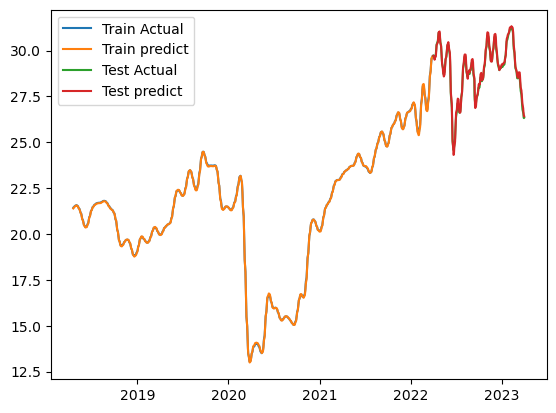

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009699217602610588
Test_MAE: 0.05299241170287132


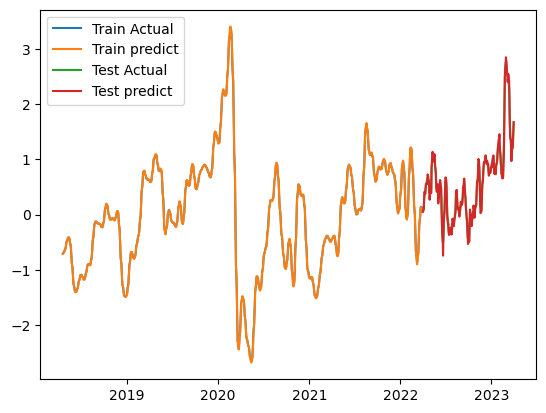

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009614323498681188
Test_MAE: 0.01607135869562626


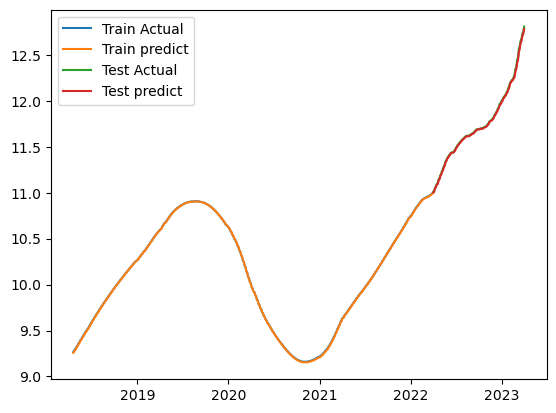

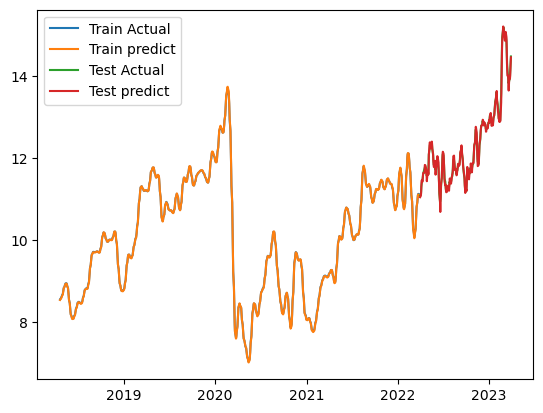

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.020192306861281394
Test_MAE: 0.0784735456109047


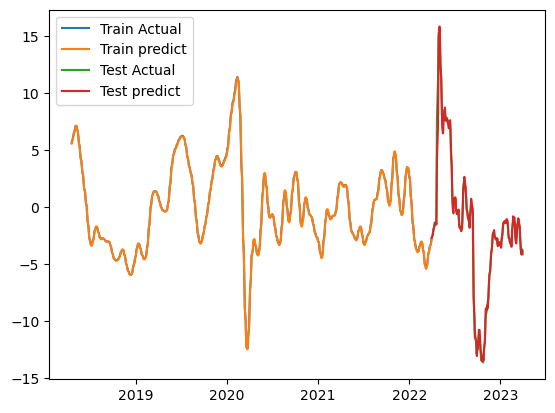

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0072482584975659846
Test_MAE: 0.021509620547294616


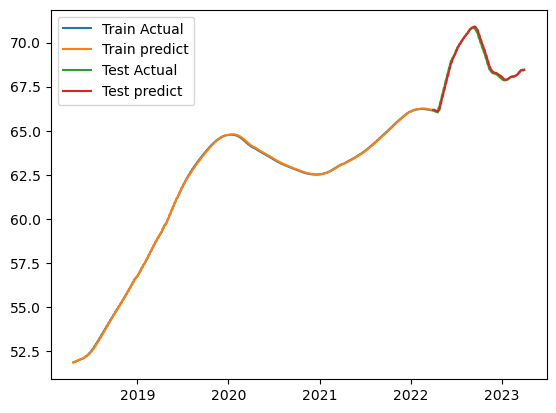

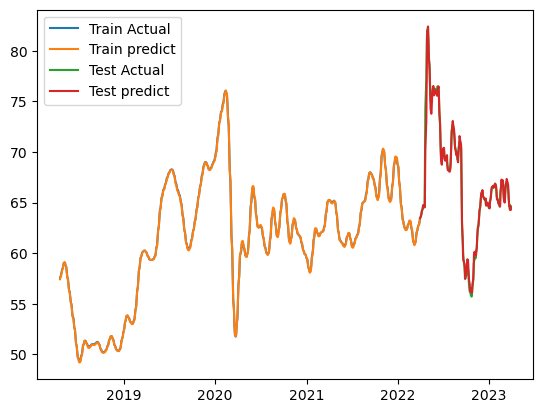

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.011650605499744416
Test_MAE: 0.05883618146181106


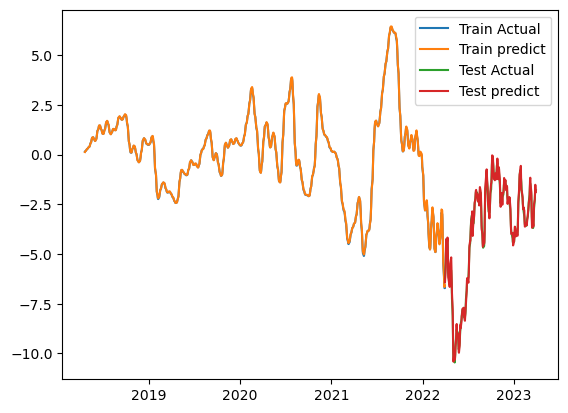

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0007005928200669587
Test_MAE: 0.024703016504645348


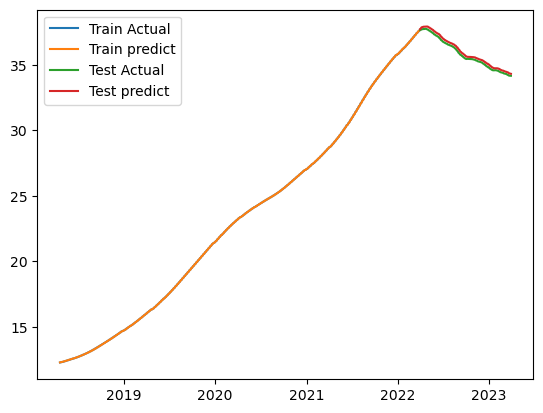

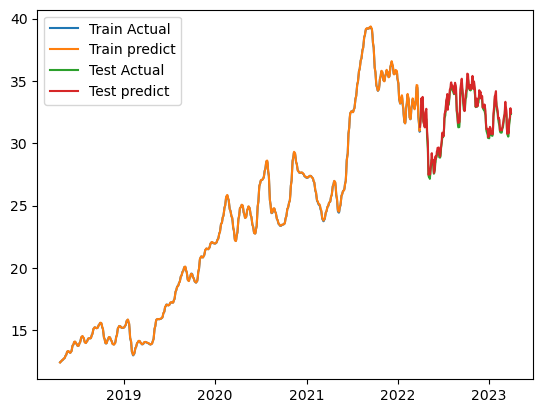

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.022609408386051653
Test_MAE: 0.043258920311927795


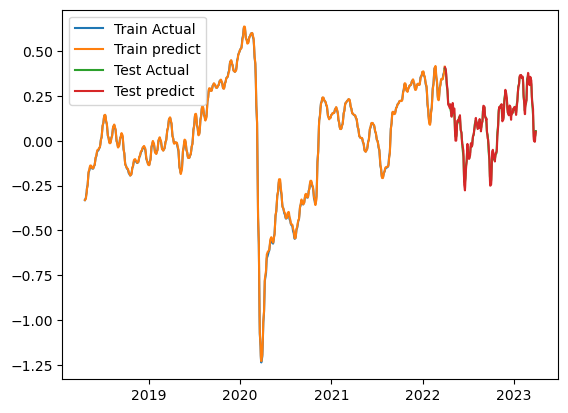

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0060631288215518
Test_MAE: 0.027597403153777122


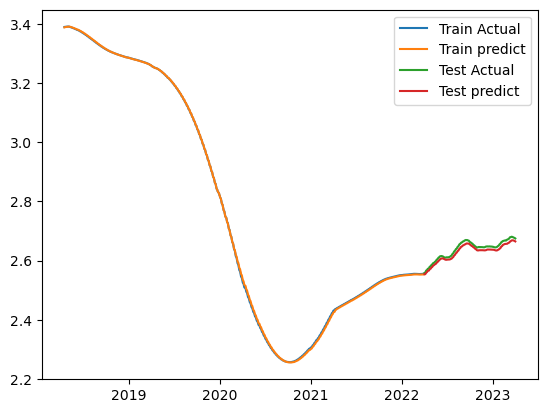

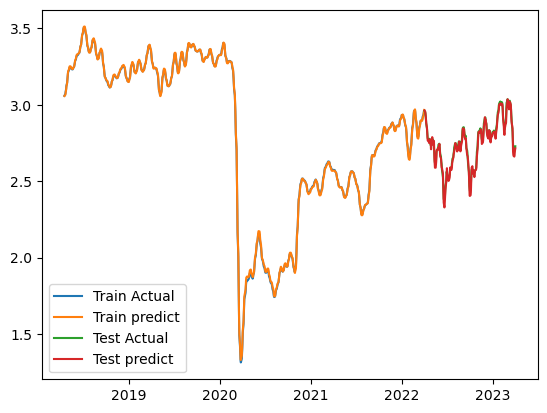

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.014078342542052268
Test_MAE: 0.03824819251894951


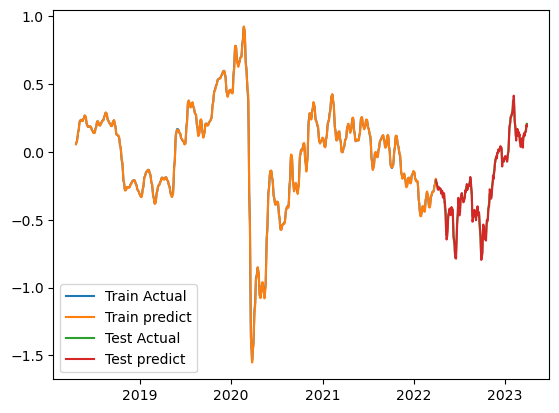

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0036270701792091133
Test_MAE: 0.036343565583229064


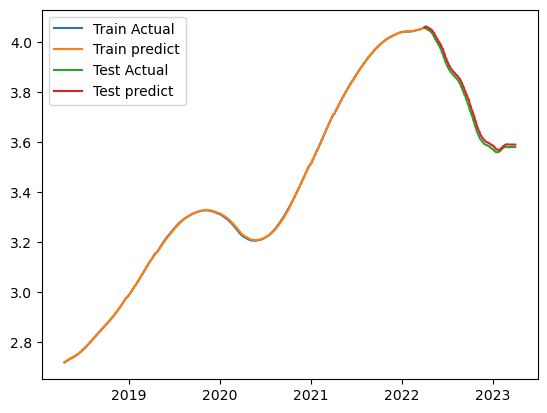

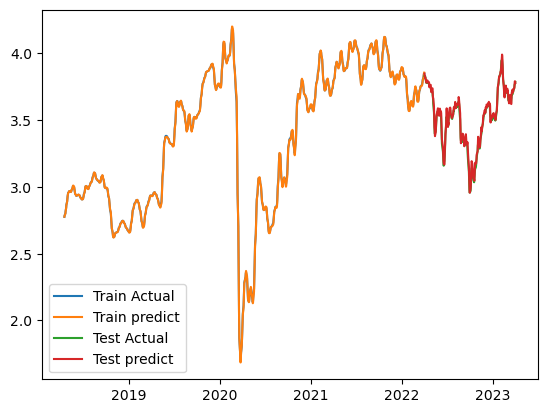

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015567556023597717
Test_MAE: 0.060843002051115036


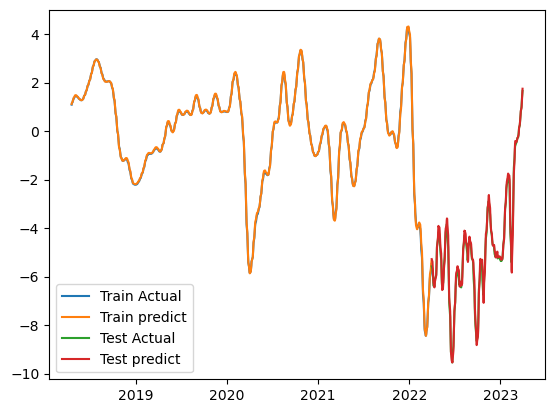

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0010560899274423719
Test_MAE: 0.028855830803513526


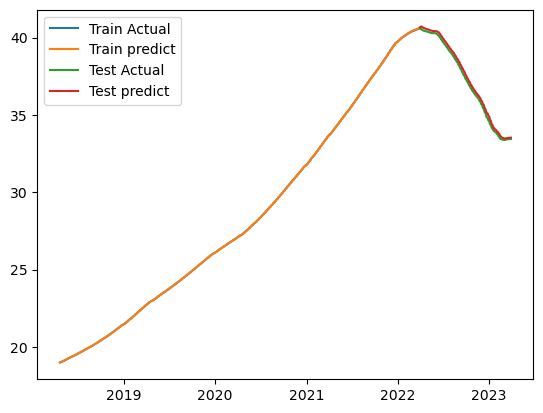

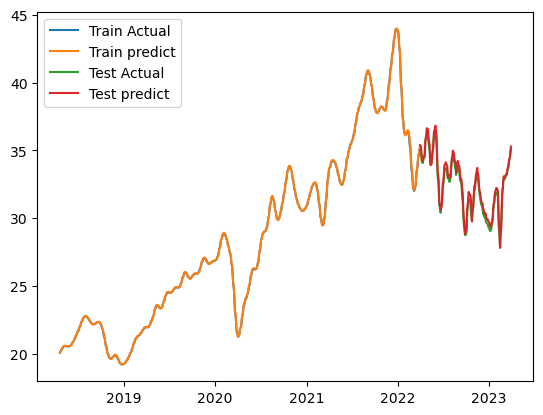

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.012512401957064868
Test_MAE: 0.04513547718524933


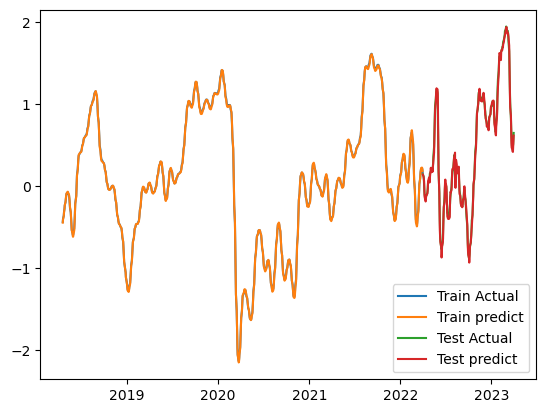

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.004785444075241685
Test_MAE: 0.024675759300589562


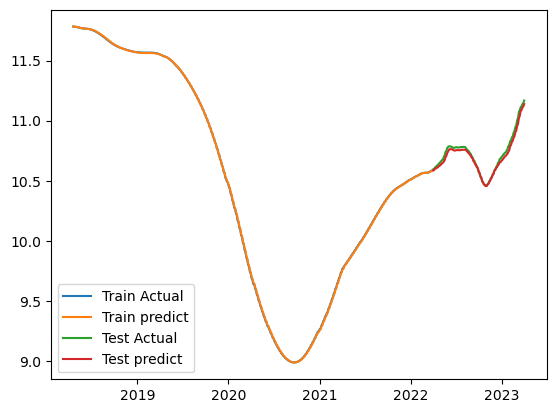

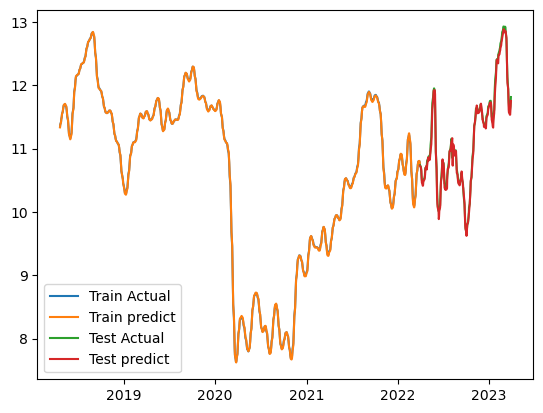

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.015673148073256017
Test_MAE: 0.03590754270553589


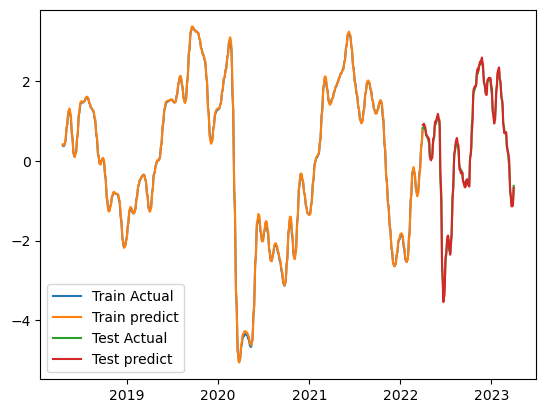

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.005410701432265341
Test_MAE: 0.004651699075475335


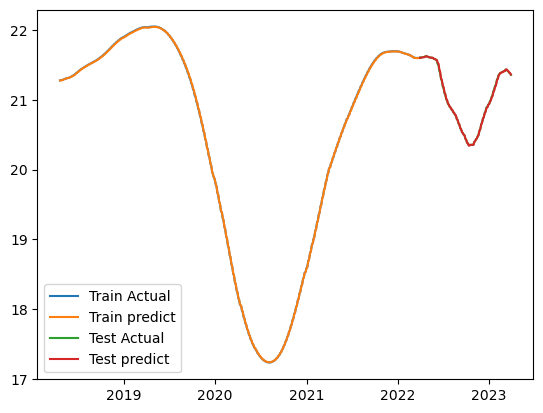

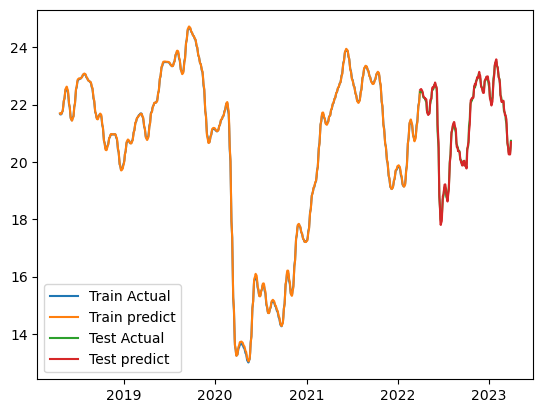

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.04314417466521263
Test_MAE: 0.19330843389034272


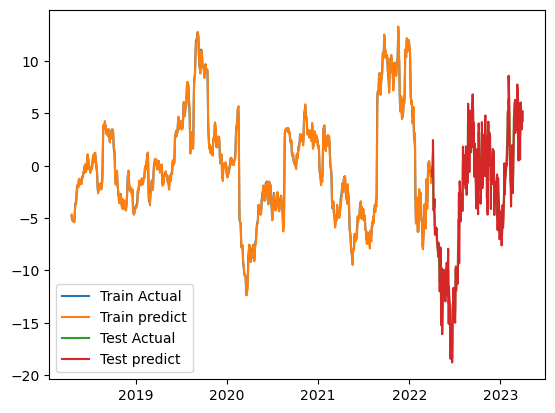

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0037307947408407927
Test_MAE: 0.03695803880691528


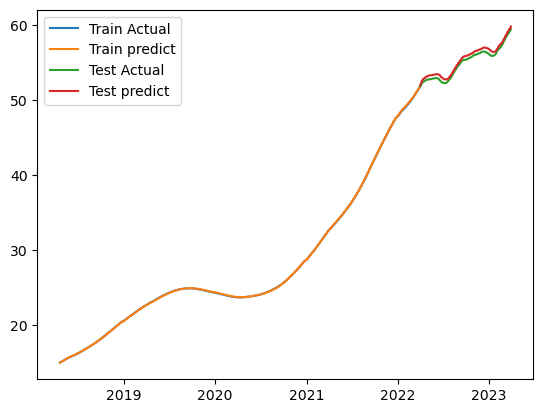

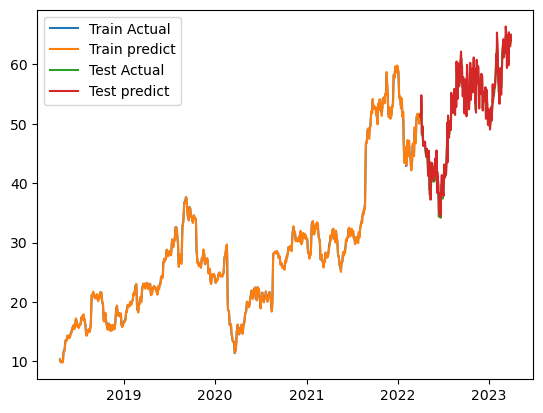

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0175712238997221
Test_MAE: 0.06180253028869629


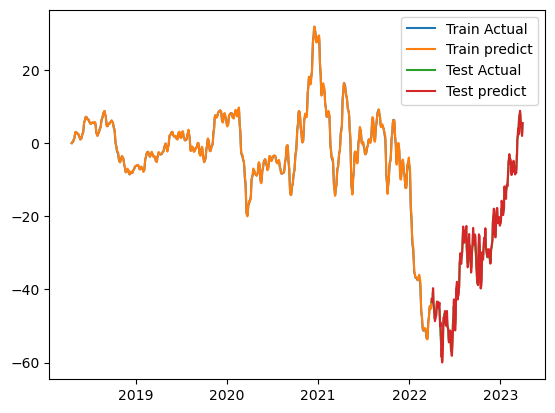

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.0013855792116373778
Test_MAE: 0.0329662561416626


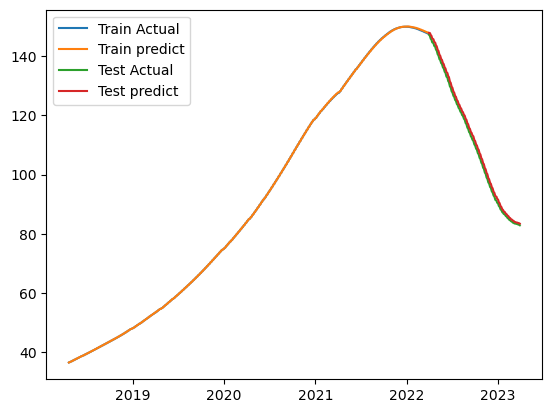

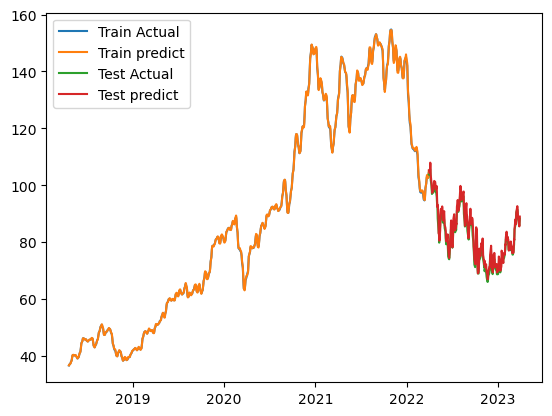

In [12]:
obtain_all(1, show = True)

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.01869120728224516
Test_MAE: 0.031638256087899205


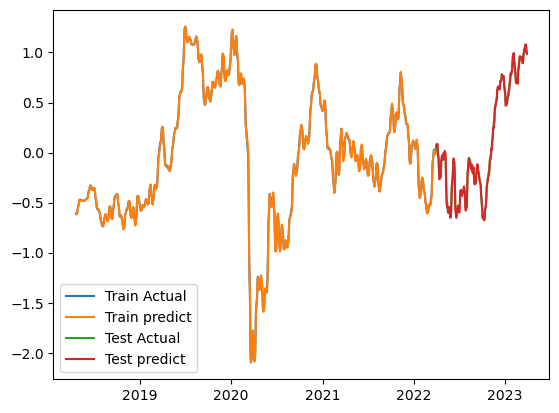

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.006683964235708118
Test_MAE: 0.004862518841400742


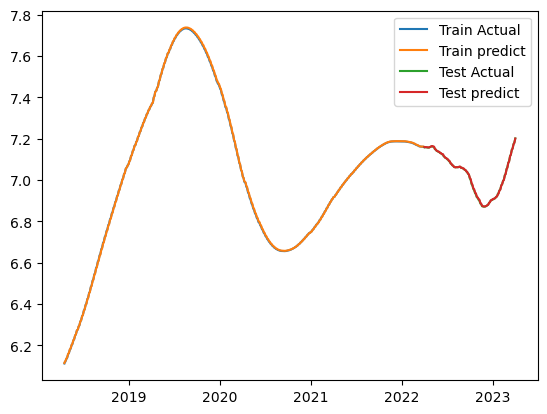

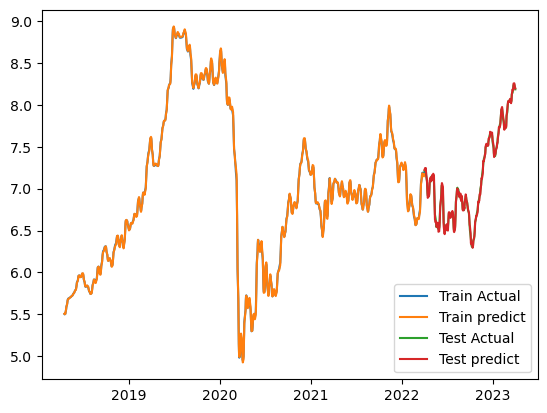

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.010567167773842812
Test_MAE: 0.0756035178899765


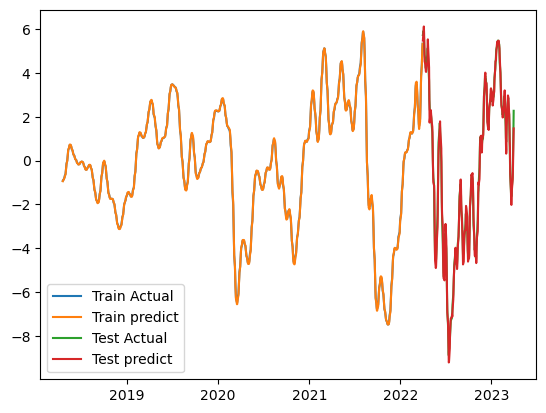

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0018440223997458816
Test_MAE: 0.013916937261819839


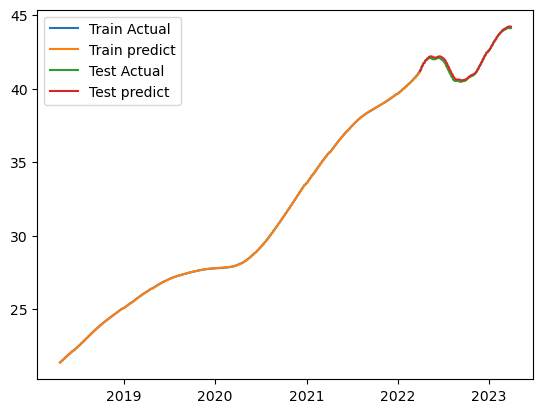

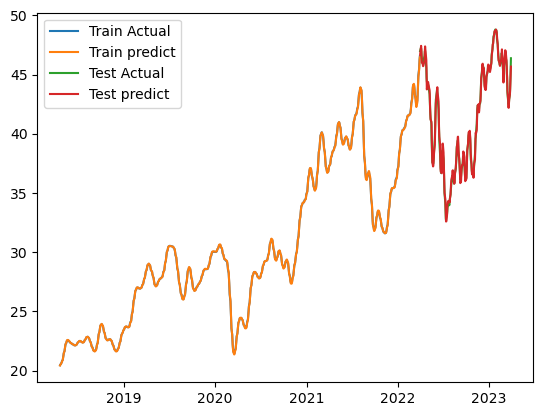

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.012384895235300064
Test_MAE: 0.03182511255145073


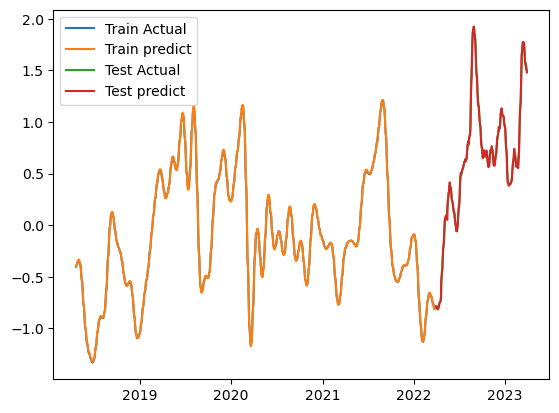

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006701765395700931
Test_MAE: 0.01509366426616907


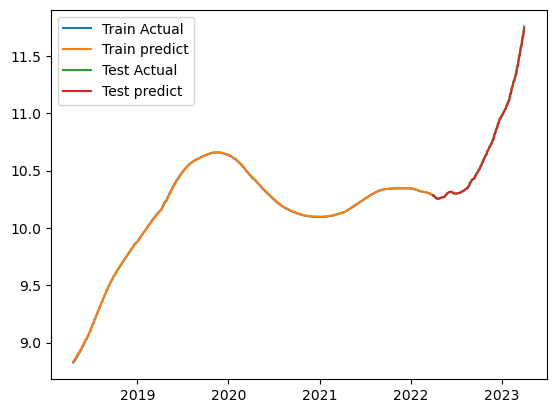

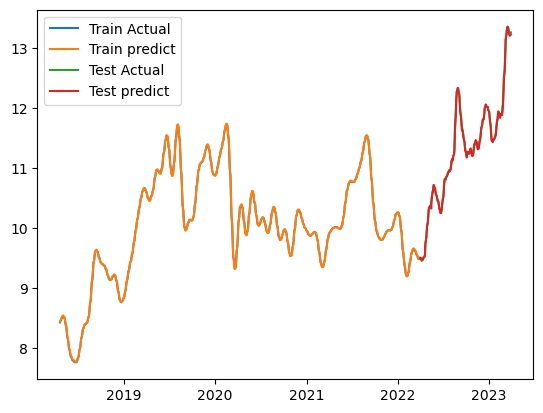

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.026869352906942368
Test_MAE: 0.14182319939136506


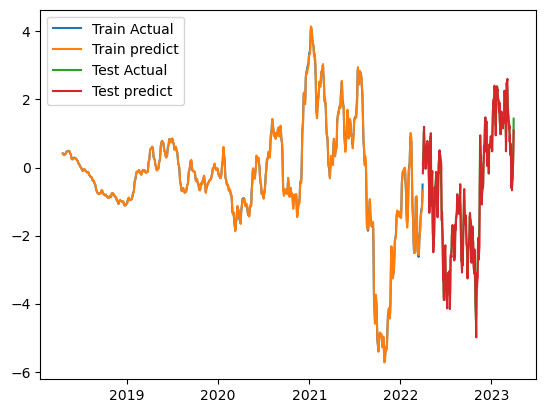

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0011599337798543275
Test_MAE: 0.008763198368251323


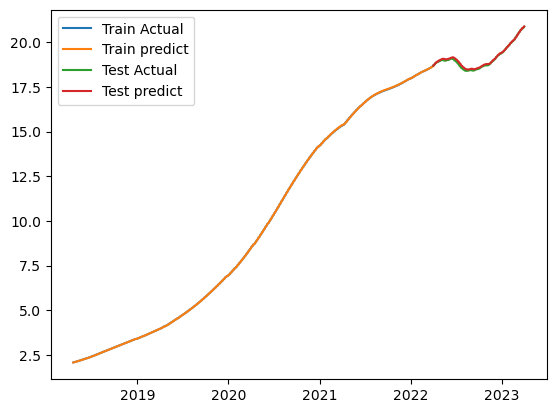

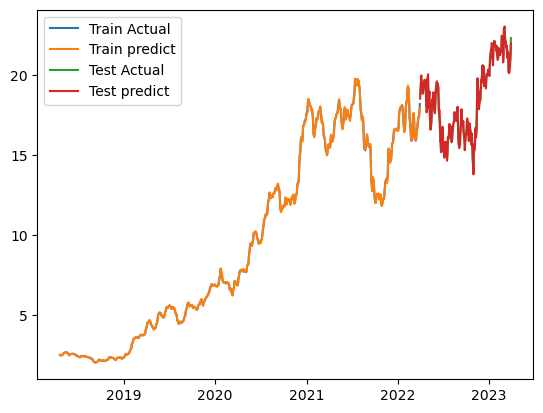

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.02506796345114708
Test_MAE: 0.2292270392179489


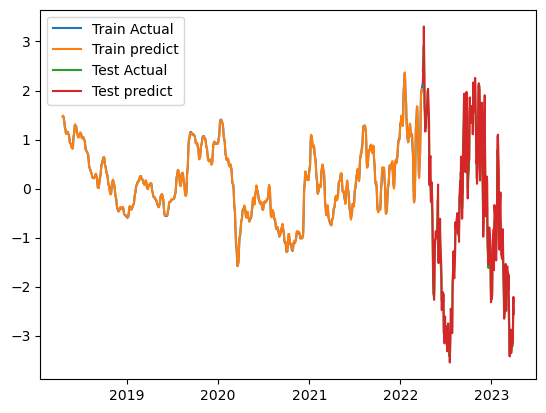

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.001923388452269137
Test_MAE: 0.04124792143702507


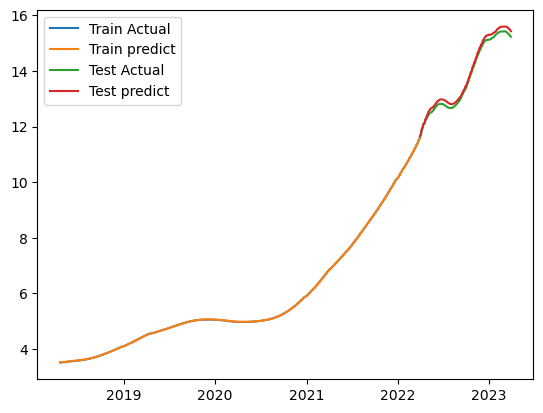

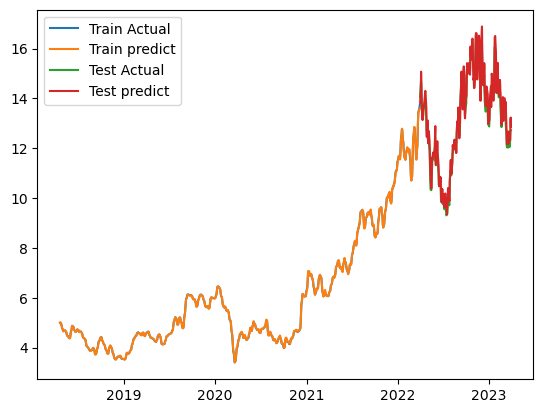

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.017375767417252063
Test_MAE: 0.05471585765480995


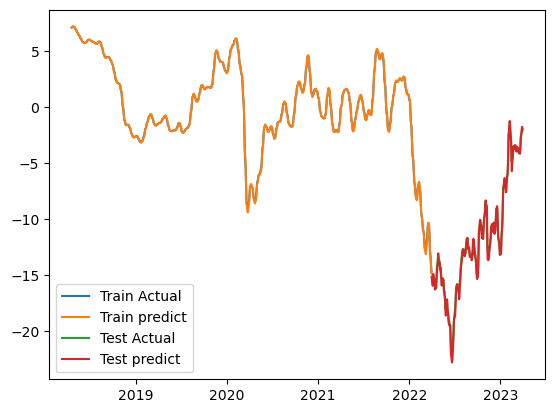

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0014957062900066375
Test_MAE: 0.03977789655327797


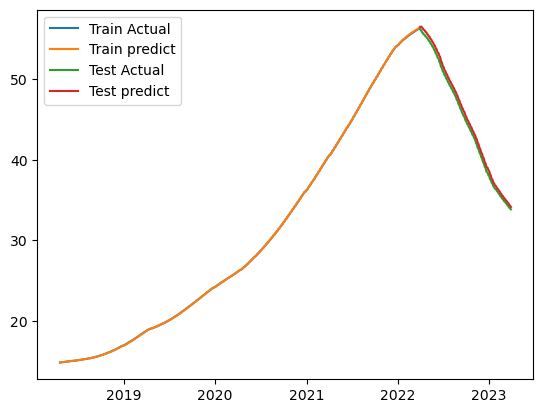

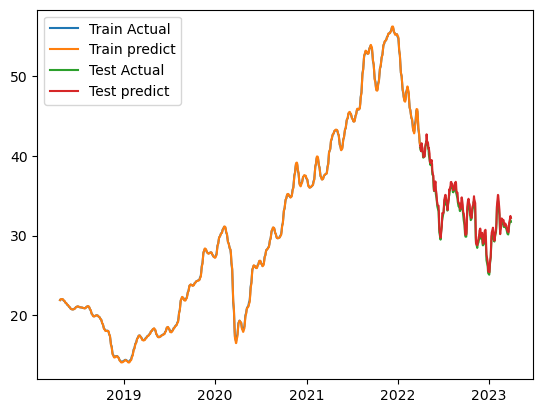

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02581828013062477
Test_MAE: 0.27938305139541625


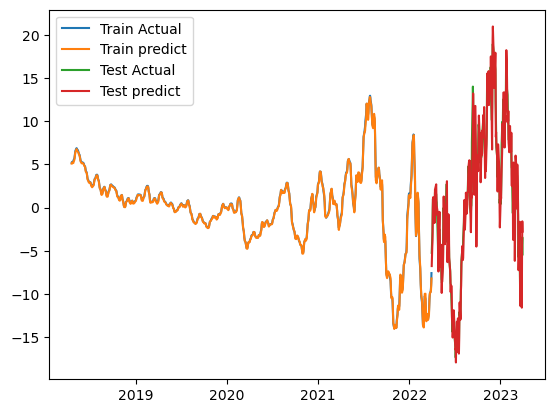

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0014908815268427134
Test_MAE: 0.013905910216271878


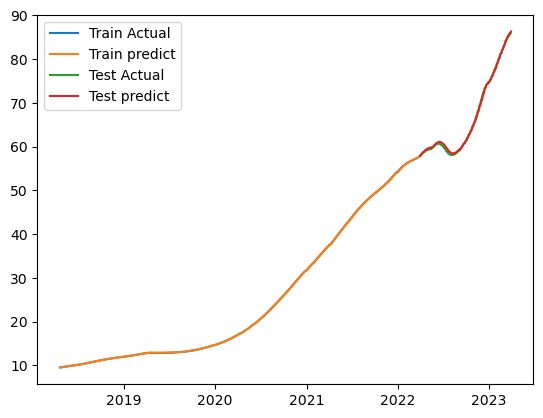

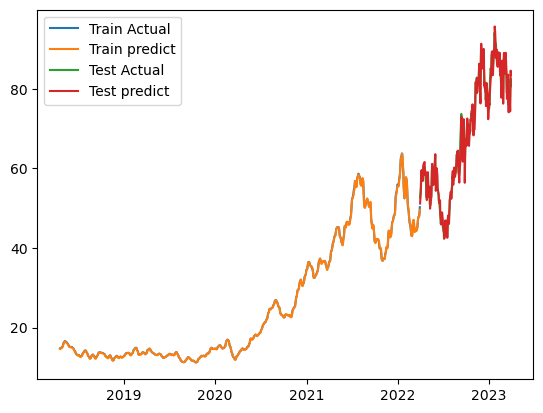

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.022603929787874222
Test_MAE: 0.05343978181481361


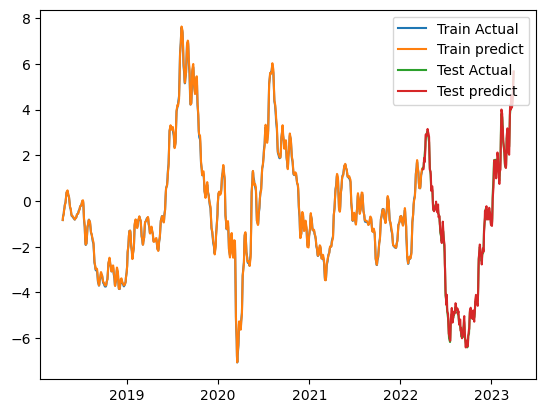

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 2ms/step
Train_MAE: 0.006734674959443509
Test_MAE: 0.02916405014693737


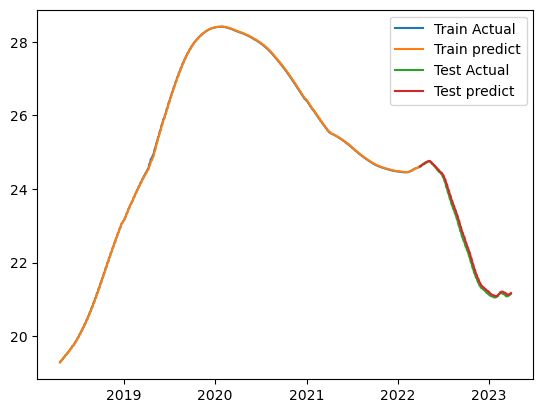

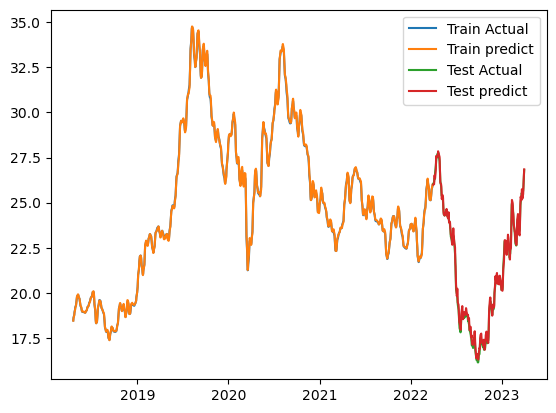

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.06051352322101593
Test_MAE: 0.12806600332260132


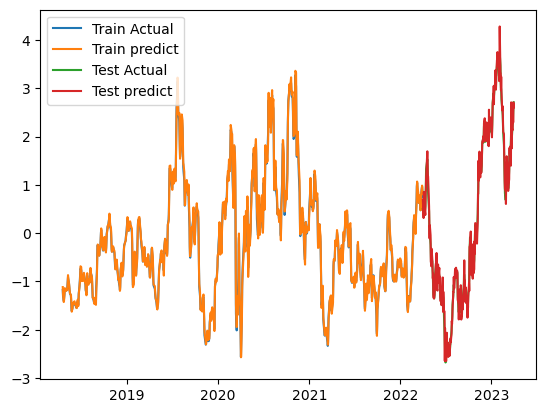

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.007110848044976592
Test_MAE: 0.016232625395059586


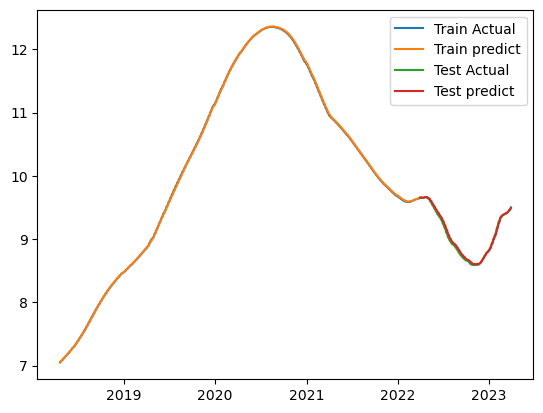

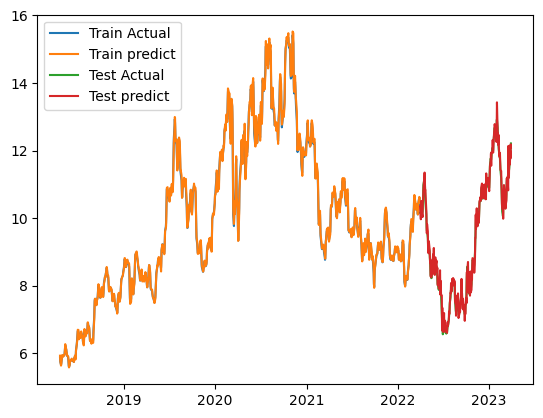

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.016489622928202153
Test_MAE: 0.08407133519649505


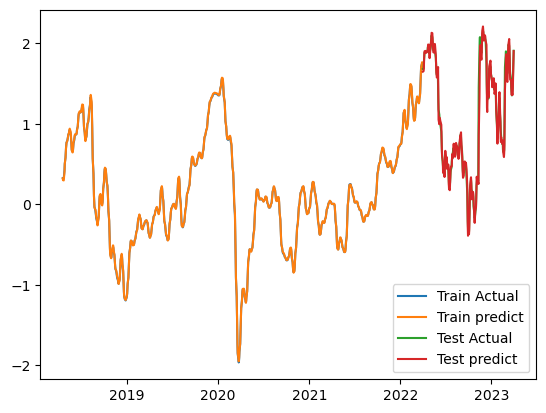

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0033791842870414257
Test_MAE: 0.04172237887978554


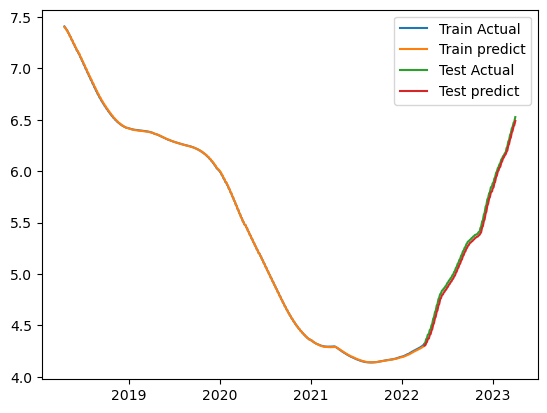

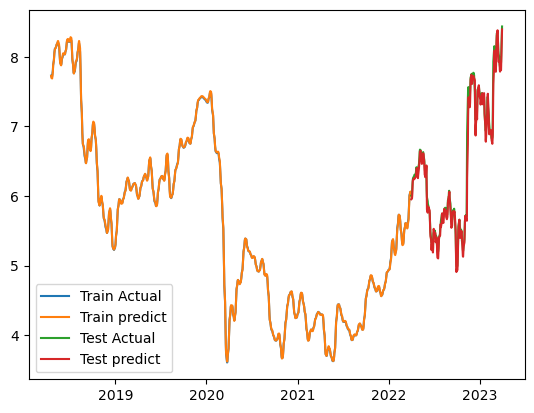

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.08629946857690811
Test_MAE: 0.3658086538314819


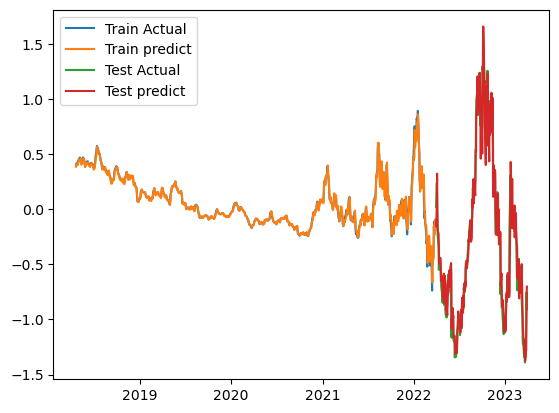

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.004291206365451217
Test_MAE: 0.04688741341233253


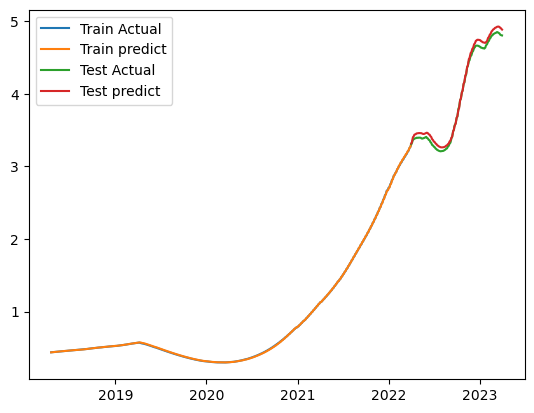

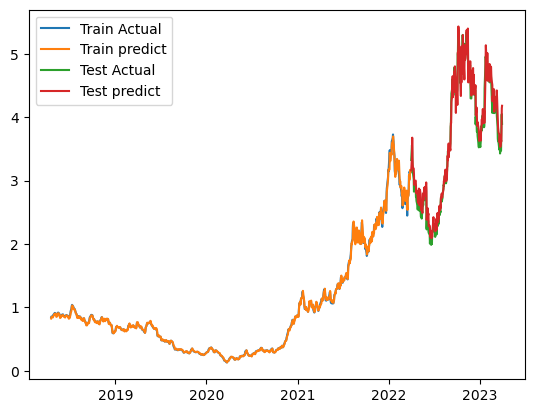

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.02085399627685547
Test_MAE: 0.06185004338622093


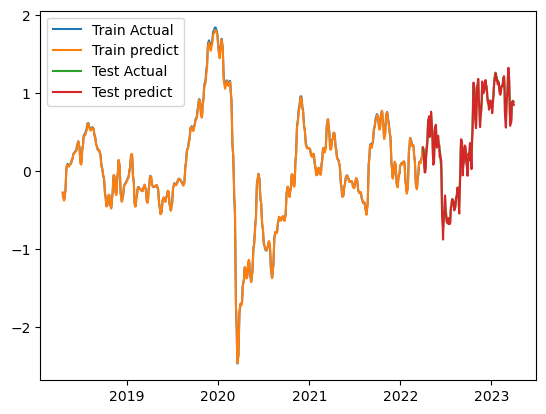

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.010088702104985714
Test_MAE: 0.046001673489809033


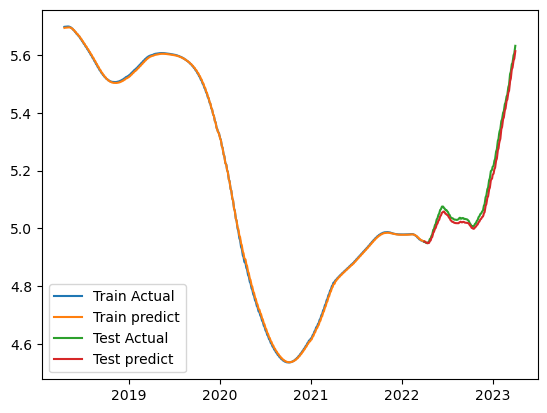

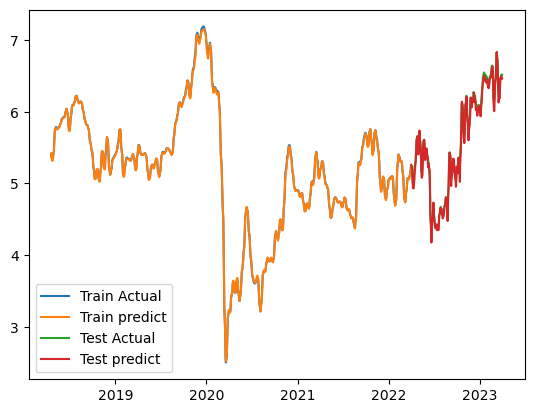

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.017092848382890224
Test_MAE: 0.06451054066419601


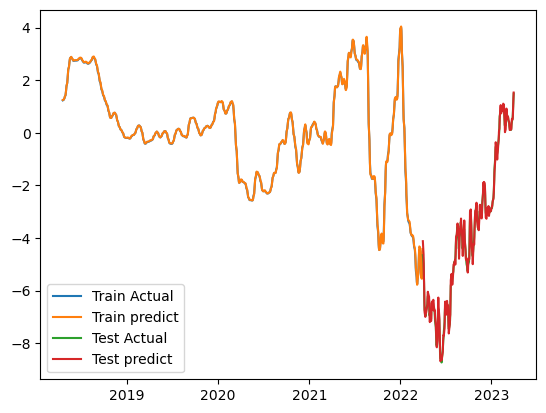

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0020151085220277308
Test_MAE: 0.03996428027749062


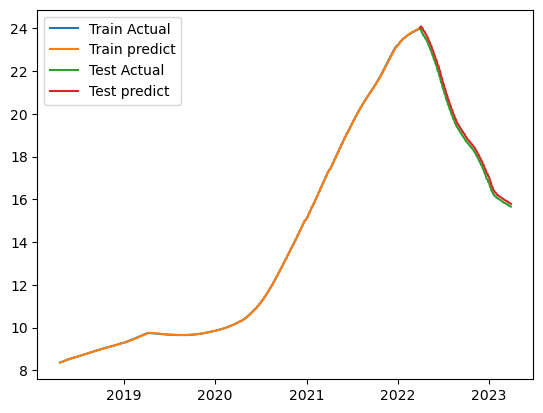

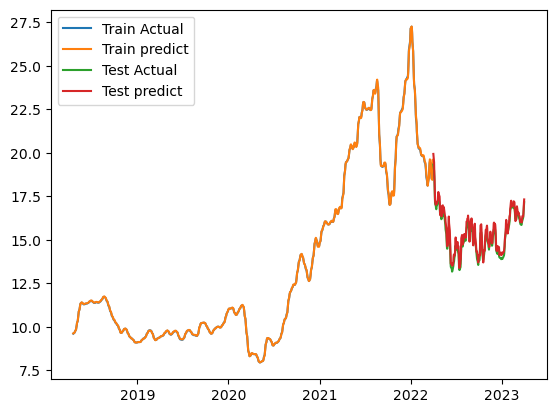

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.011050986032932997
Test_MAE: 0.06224810928106308


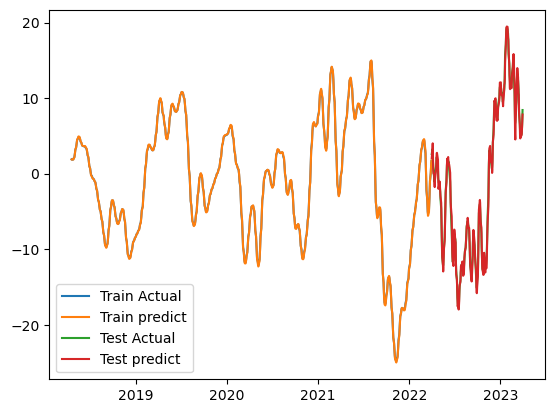

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.0013425607699900865
Test_MAE: 0.014960006438195705


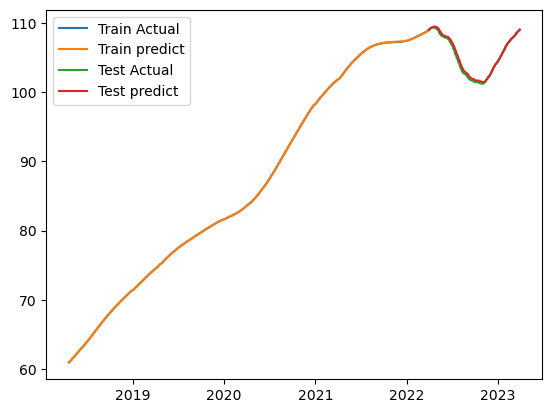

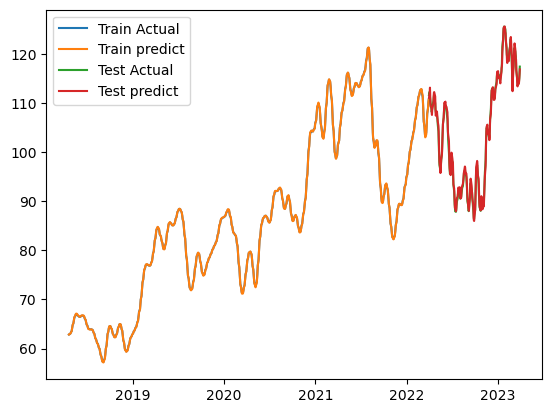

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.017024008743464946
Test_MAE: 0.11472421139478683


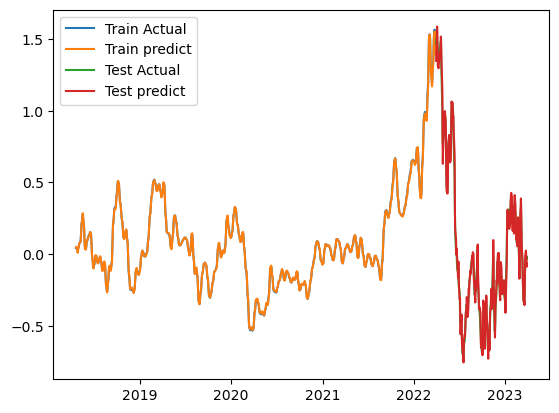

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.009452453907579183
Test_MAE: 0.026467416435480118


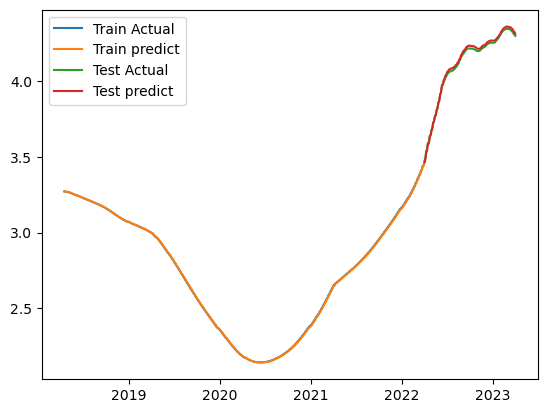

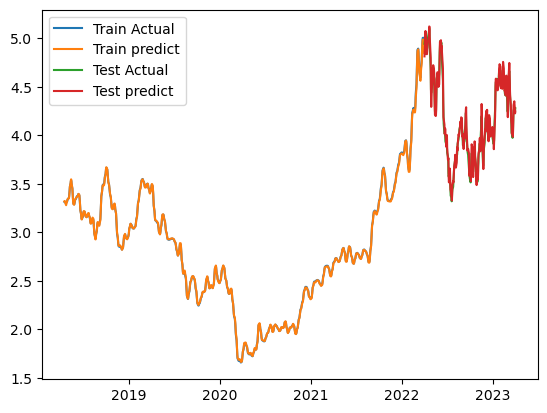

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.015426812320947647
Test_MAE: 0.03314114473760128


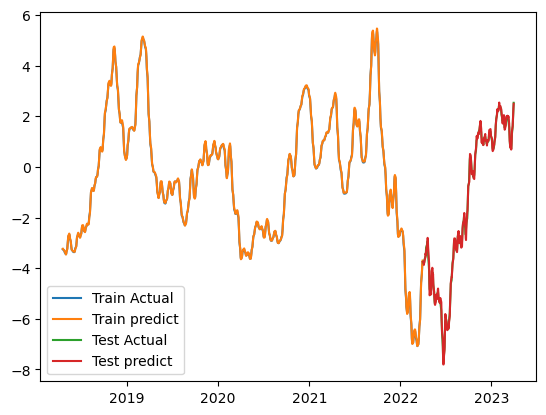

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.006181835010647774
Test_MAE: 0.03997422382235527


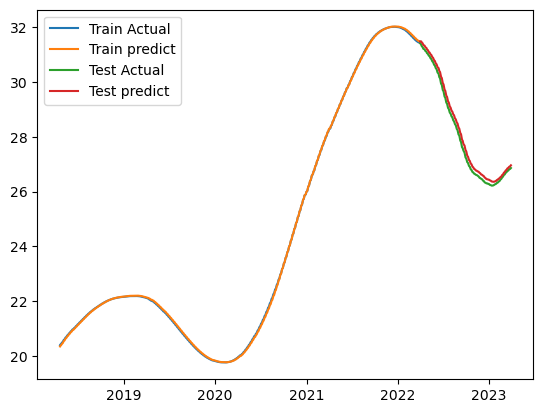

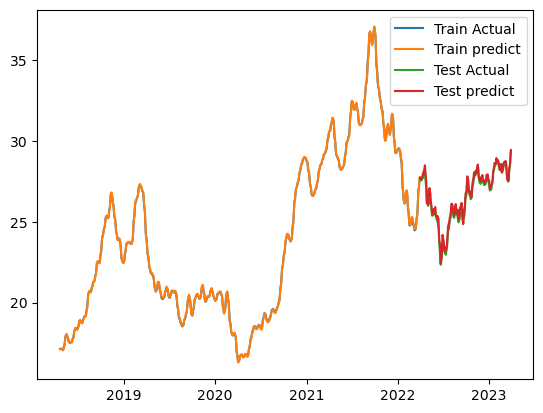

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.027057362347841264
Test_MAE: 0.0637764260172844


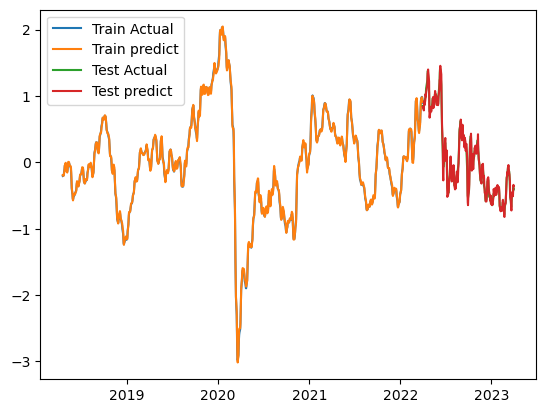

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.0025809063110500572
Test_MAE: 0.014529315568506718


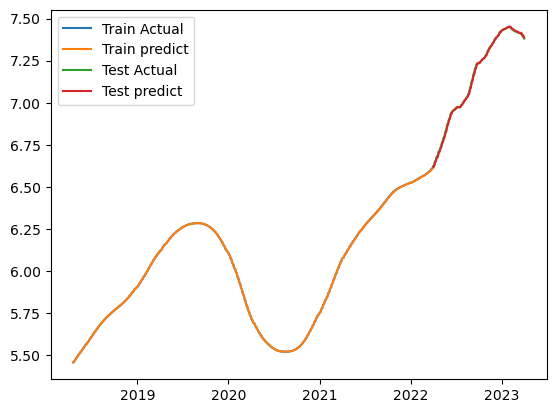

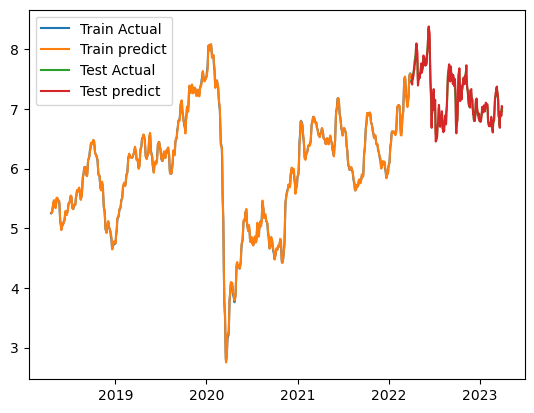

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.018252591043710707
Test_MAE: 0.03786878138780594


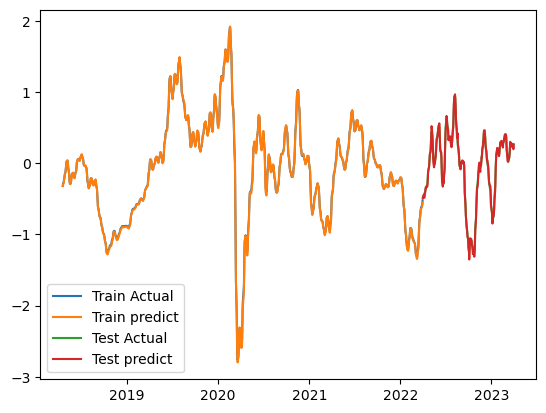

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.003362227836623788
Test_MAE: 0.00814055809751153


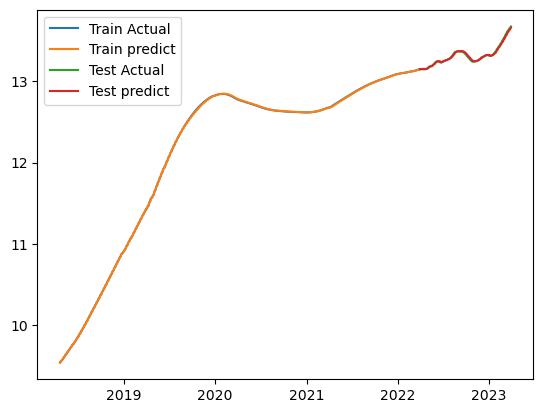

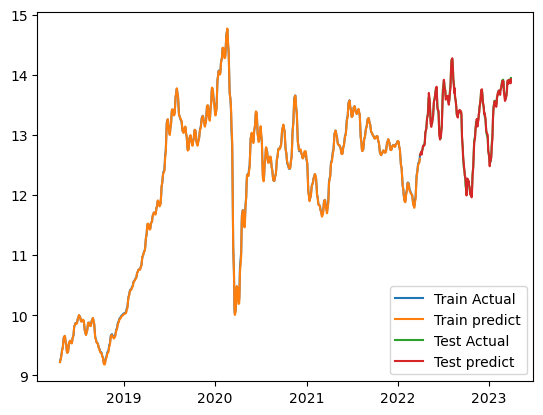

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 4ms/step
Train_MAE: 0.018551890552043915
Test_MAE: 0.07647387236356736


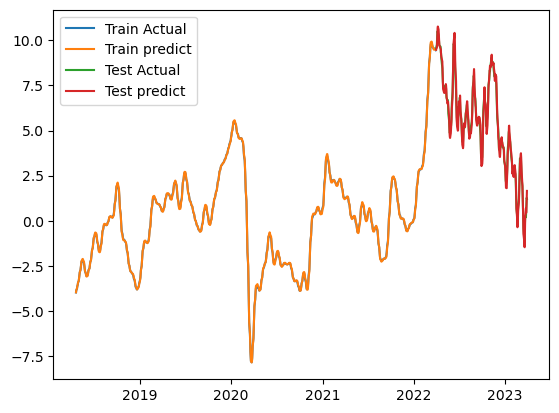

train_series_shape: (1008,)
test_series_shape: (252,)
X_train: (1003, 5, 1)
Y_train: (1003, 1, 1)
X_test: (252, 5, 1)
Y_test: (252, 1, 1)
8/8 [==============================] - 0s 3ms/step
Train_MAE: 0.003922863025218248
Test_MAE: 0.048614146560430525


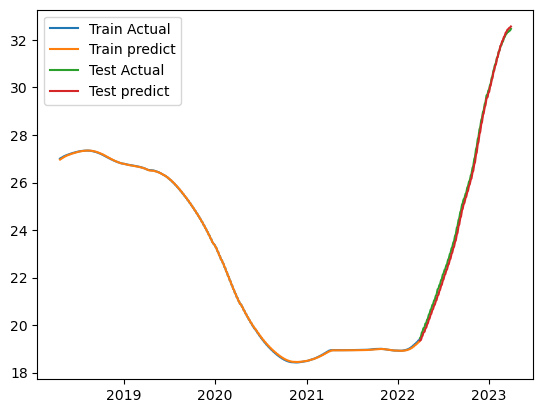

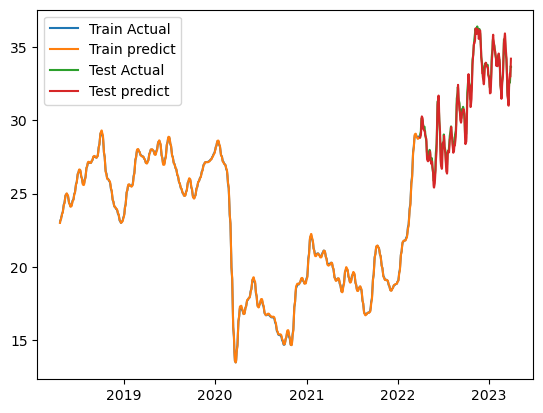

In [13]:
obtain_all(2, show = True)